### Pediatric Sepsis: In-hospital Mortality Prediction

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

# Random Forest Model fitting
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, f1_score
from imblearn.pipeline import Pipeline  # ✅ Use this instead of sklearn.pipeline
from imblearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve


from sklearn.model_selection import learning_curve
from sklearn.feature_selection import VarianceThreshold

### Importing the dataset

In [274]:
sepsis_df = pd.read_csv("SyntheticData_Training.csv") 
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
sepsis_df.head()

,studyid_adm,agecalc_adm,height_cm_adm,weight_kg_adm,muac_mm_adm,hr_bpm_adm,rr_brpm_app_adm,sysbp_mmhg_adm,diasbp_mmhg_adm,temp_c_adm,...,cookloc_adm,lightfuel_adm,tobacco_adm,bednet_adm,hctpretransfusion_adm,hivstatus_adm,malariastatuspos_adm,lengthadm,caregiver_adm_new,inhospital_mortality
0,1,16.8,79.8,11.6,150.0,130.0,23.0,92.0,54.0,36.3,...,In a separate building/building space used as ...,Electric bulbs (national grid),Never,Always,Yes,HIV negative,No,2,Mother,0
1,2,46.1,93.0,13.6,151.0,115.0,35.0,72.0,42.0,36.8,...,In a separate building/building space used as ...,Tadooba,Never,Always,Yes,HIV negative,Yes,5,Mother,0
2,3,7.9,68.2,8.2,148.0,150.0,56.0,94.0,51.0,37.2,...,In a separate building/building space used as ...,Tadooba,Never,Always,Yes,HIV negative,No,4,Mother,0
3,4,38.2,95.0,12.0,138.0,134.0,38.0,94.0,57.0,37.6,...,In the house where you sleep,Electric bulbs (national grid),Never,Always,NaN,HIV negative,Yes,5,Mother,0
4,5,16.1,83.0,12.0,165.0,163.0,61.0,107.0,73.0,38.7,...,Outdoors in the open,Electric bulbs (national grid),Never,Sometimes,Yes,HIV negative,Yes,7,Mother,0


### Looking into the data structure

In [275]:
sepsis_df.info()
pd.set_option('display.max_rows', None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Columns: 138 entries, studyid_adm to inhospital_mortality
dtypes: float64(23), int64(3), object(112)
memory usage: 2.8+ MB


In [276]:
sepsis_df.duplicated().sum()

0

### Understanding the Column Characteristics

In [277]:
#Create a summary DataFrame of column characteristics

column_summary= pd.DataFrame({'Column': sepsis_df.columns, 
                              'Data Type': sepsis_df.dtypes.values,
                              'Missing Values': sepsis_df.isnull().sum().values,
                              'Missing %': (sepsis_df.isnull().mean() * 100).values,
                              'Unique Values': sepsis_df.nunique().values})



# Display all rows in the column summary
pd.set_option('display.max_rows', None)

# Print
print(column_summary)

                       Column Data Type  Missing Values  Missing %  \
0                 studyid_adm     int64               0   0.000000   
1                 agecalc_adm   float64               0   0.000000   
2               height_cm_adm   float64              14   0.521221   
3               weight_kg_adm   float64               9   0.335071   
4                 muac_mm_adm   float64              13   0.483991   
5                  hr_bpm_adm   float64               1   0.037230   
6             rr_brpm_app_adm   float64               5   0.186150   
7              sysbp_mmhg_adm   float64               2   0.074460   
8             diasbp_mmhg_adm   float64               1   0.037230   
9                  temp_c_adm   float64               1   0.037230   
10       spo2site1_pc_oxi_adm   float64               4   0.148920   
11       spo2site2_pc_oxi_adm   float64             205   7.632167   
12              spo2other_adm   float64            2505  93.261355   
13                 m

## Data Cleaning

### Checking Missing Values

In [278]:
#pd.set_option('display.max_rows', None)
sepsis_df.isnull().sum()

studyid_adm                    0
agecalc_adm                    0
height_cm_adm                 14
weight_kg_adm                  9
muac_mm_adm                   13
hr_bpm_adm                     1
rr_brpm_app_adm                5
sysbp_mmhg_adm                 2
diasbp_mmhg_adm                1
temp_c_adm                     1
spo2site1_pc_oxi_adm           4
spo2site2_pc_oxi_adm         205
spo2other_adm               2505
momage_adm                    19
momagefirstpreg_adm          224
householdsize_adm              3
alivechildren_adm              4
deadchildren_adm               1
hematocrit_gpdl_adm          457
lactate_mmolpl_adm           464
lactate2_mmolpl_adm         2217
glucose_mmolpl_adm             9
sqi1_perc_oxi_adm            130
sqi2_perc_oxi_adm            207
sex_adm                        0
spo2onoxy_adm                  4
oxygenavail_adm                0
respdistress_adm               2
caprefill_adm                  1
bcseye_adm                     1
bcsmotor_a

### Dropping columns

#### 1. Dropping the Intervention Columns

Dropped intervention columns: These variables represent treatments that, while powerful predictors, are excluded due to their post-admission nature. The model, however, relies on data available at the time of admission.

In [279]:
# Filter columns that start with 'admitabx_adm_'
abx_cols = [col for col in sepsis_df.columns if col.startswith('admitabx_adm_')]

# Count rows where all selected columns are 'Unchecked'
all_unchecked_rows = sepsis_df[abx_cols].apply(lambda row: (row == 'Unchecked').all(), axis=1)

# Print the number of such rows
print(f"Number of rows where all 'admitabx_adm_' columns are 'Unchecked': {all_unchecked_rows.sum()}")


Number of rows where all 'admitabx_adm_' columns are 'Unchecked': 45


In [280]:
# Removing leading/trailing whitespace
sepsis_df.columns = sepsis_df.columns.str.strip()

# Define the intervention columns we want to drop
intervention_cols = [f"admitabx_adm___{i}" for i in range(1, 22)]

# Dropping them
sepsis_df.drop(columns=intervention_cols, inplace=True, errors='ignore')

# Confirming
print("Remaining columns:", sepsis_df.shape[1])
print("Dropped intervention columns:", intervention_cols)


Remaining columns: 117
Dropped intervention columns: ['admitabx_adm___1', 'admitabx_adm___2', 'admitabx_adm___3', 'admitabx_adm___4', 'admitabx_adm___5', 'admitabx_adm___6', 'admitabx_adm___7', 'admitabx_adm___8', 'admitabx_adm___9', 'admitabx_adm___10', 'admitabx_adm___11', 'admitabx_adm___12', 'admitabx_adm___13', 'admitabx_adm___14', 'admitabx_adm___15', 'admitabx_adm___16', 'admitabx_adm___17', 'admitabx_adm___18', 'admitabx_adm___19', 'admitabx_adm___20', 'admitabx_adm___21']


#### 2. Dropping other additional Columns

In [281]:
# Dropping unnecessary columns
sepsis_df = sepsis_df.drop(["spo2other_adm","lactate2_mmolpl_adm","nonexclbreastfed_adm","vaccmeaslessource_adm"], axis=1)

#### Justification for dropping
___
* **"spo2other\_adm" dropped:** Represents oxygen saturation with another device (redundant), and has 93.3% missing values.
* **"lactate2\_mmolpl\_adm" dropped:** A similar measurement is available, and it has 82.54% missing values.
* **"nonexclbreastfed\_adm" dropped:** Represents non-exclusive breastfeeding details, with 96.91% missing values.
* **"vaccmeaslessource\_adm" dropped:** Represents the source of information regarding measles vaccination (found to be less important), with 35.22% missing values.
___

### Handling Missing Values

#### 1. Numerical Variables with Missing Values

*Clean numeric-columns*

In [282]:
# Get columns that have at least one missing value
cols_with_missing = sepsis_df.columns[sepsis_df.isnull().any()].tolist()

# Create a new DataFrame with only those columns
df_missing_subset = sepsis_df[cols_with_missing]

# Select numeric columns only
numeric_cols = df_missing_subset.select_dtypes(include='number')

# Calculate skewness for each numeric column
skewness = numeric_cols.skew()

# Filter columns where skewness is between -0.5 and +0.5
symmetric_cols = skewness[(skewness > -0.5) & (skewness < 0.5)].index.tolist()

print("Columns with fairly symmetric distributions:", symmetric_cols)

Columns with fairly symmetric distributions: ['muac_mm_adm', 'sysbp_mmhg_adm', 'diasbp_mmhg_adm', 'hematocrit_gpdl_adm']


___
Columns with fairly symmetric distributions (skewness between -0.5 and 0.5) were identified using the `.skew()` function and separated for imputation using the **mean**. For columns with more skewed distributions (skewness < -0.5 or > 0.5), the **median** will be used instead, as it's more robust to outliers.
___

#### Imputing the columns with fairly symmetric distributions using mean

In [283]:
sepsis_df[['sysbp_mmhg_adm', 'diasbp_mmhg_adm']] = sepsis_df[['sysbp_mmhg_adm', 'diasbp_mmhg_adm']].fillna(sepsis_df[['sysbp_mmhg_adm', 'diasbp_mmhg_adm']].mean())

#### Imputing 'height_cm_adm' column

In [284]:
# Show relevant info where height is missing
sepsis_df.loc[sepsis_df['height_cm_adm'].isnull(), ['weight_kg_adm', 'agecalc_adm', 'sex_adm']]

,weight_kg_adm,agecalc_adm,sex_adm
370,13.0,23.3,Male
430,NaN,29.0,Male
858,NaN,30.1,Female
928,NaN,26.9,Male
956,5.8,22.0,Male
1025,NaN,15.5,Male
1178,13.0,52.2,Female
1360,NaN,21.2,Female
1785,9.0,22.5,Male
1855,9.0,10.6,Male


* To handle missing values in the height_cm_adm column, the approach involves imputing the missing heights using the WHO median height-for-age data. The patient's age in months is rounded to the nearest whole number to align with the WHO data, which includes median height values for different age months. The missing values in the height_cm_adm column are then filled with the corresponding median height from the WHO dataset based on the patient's rounded age.
  
* This method ensures that the imputed heights are age-appropriate and based on established growth standards, improving the overall quality of the dataset for analysis.

##### *For Female*

In [285]:
# Loading the WHO dataset for girls
who_girls = pd.read_csv("girls_length_height_for_age.csv")

In [286]:
# Round age to match WHO months
sepsis_df['age_months_rounded'] = sepsis_df['agecalc_adm'].round().astype(int)

# Prepare WHO data
who_clean = who_girls[['Months', 'Median']].rename(columns={
    'Months': 'age_months_rounded',
    'Median': 'who_median_height'
})

# Merge on the rounded age
sepsis_df = sepsis_df.merge(
    who_clean,
    on='age_months_rounded',
    how='left'
)

* The patient's age in months is rounded to the nearest whole number to align with the WHO data. The WHO median height-for-age data for girls is then cleaned and merged with the sepsis dataset based on the rounded age.

* This ensures that each patient is matched with the appropriate WHO median height based on their age.

In [287]:
# Identify missing heights for female patients
girls_mask = (sepsis_df['sex_adm'] == 'Female') & (sepsis_df['height_cm_adm'].isna())

# Impute with WHO median height based on rounded age
sepsis_df.loc[girls_mask, 'height_cm_adm'] = sepsis_df.loc[girls_mask, 'who_median_height']

* This code identifies missing height values for female patients by creating a mask where the sex_adm is 'Female' and height_cm_adm is null.

* Then, for these patients, the missing height values are imputed using the corresponding WHO median height based on the patient's rounded age in months.

##### *For Male*

In [288]:
# Loading the WHO dataset for boys
who_boys = pd.read_csv("boys_length_height_for_age.csv")

In [289]:
# Round age to match WHO months
sepsis_df['age_months_rounded'] = sepsis_df['agecalc_adm'].round().astype(int)

# Prepare WHO data
who_clean_boys = who_boys[['Months', 'Median']].rename(columns={
    'Months': 'age_months_rounded',
    'Median': 'who_median_height_boys'
})

# Merge on the rounded age
sepsis_df = sepsis_df.merge(
    who_clean_boys,
    on='age_months_rounded',
    how='left'
)

* In this process, the age calculation of the children in the sepsis dataset is rounded to the nearest whole month using the agecalc_adm column. This rounded age is stored in a new column age_months_rounded.

* Next, the WHO data for boys is prepared by extracting the relevant columns (Months and Median) from the who_boys dataset and renaming them to age_months_rounded and who_median_height_boys, ensuring consistency with the sepsis dataset.

* Finally, the two datasets are merged based on the rounded age (age_months_rounded), allowing the sepsis dataset to be enriched with the WHO median height for boys based on the rounded age, creating a column called who_median_height_boys in the sepsis_df.

In [290]:
# Identify missing heights for male patients
boys_mask = (sepsis_df['sex_adm'] == 'Male') & (sepsis_df['height_cm_adm'].isna())

# Impute with WHO median height based on rounded age for boys
sepsis_df.loc[boys_mask, 'height_cm_adm'] = sepsis_df.loc[boys_mask, 'who_median_height_boys']

# Check for missing values again
sepsis_df['height_cm_adm'].isna().sum()

0

* This process identifies missing height values (height_cm_adm) for male patients in the dataset.
* For those missing values, the heights are imputed using the WHO median height for boys based on the rounded age.
* After the imputation, the number of remaining missing height values is checked to confirm the success of the imputation of the **height_cm_adm** column.

#### Imputing 'weight_kg_adm' column

* To impute missing weight values in the dataset, we used a reference-based approach leveraging the WHO weight-for-age data. By rounding the age of each patient to the nearest integer, we matched it with the corresponding median weight for boys and girls from the WHO dataset. This allowed us to impute missing weights based on the median value for the given age and sex, ensuring a more accurate and contextually relevant imputation method.

In [291]:
# Load WHO data
boys_wfa = pd.read_csv("boys_weight_for_age.csv")  
girls_wfa = pd.read_csv("girls_weight_for_age.csv") 

In [292]:
# Round the age to the nearest integer
sepsis_df['agecalc_adm_rounded'] = sepsis_df['agecalc_adm'].round().astype(int)

# Function to impute missing weight values
def impute_weight(row):
    if pd.isna(row['weight_kg_adm']):
        if row['sex_adm'] == 'Male':
            # Get the median weight for boys based on the agecalc_adm
            ref = boys_wfa[boys_wfa['Months'] == row['agecalc_adm_rounded']]['Median'].values[0]
        else:
            # Get the median weight for girls based on the agecalc_adm
            ref = girls_wfa[girls_wfa['Months'] == row['agecalc_adm_rounded']]['Median'].values[0]
        return ref
    return row['weight_kg_adm']

# Apply the imputation to the dataset
sepsis_df['weight_kg_adm'] = sepsis_df.apply(impute_weight, axis=1)

# Check for missing values again
sepsis_df['weight_kg_adm'].isna().sum()

0

* The process of imputing missing values in the weight_kg_adm column begins by loading the WHO weight-for-age datasets for boys and girls. The age column (agecalc_adm) in the sepsis_df dataset is then rounded to the nearest integer to match the age format used in the WHO datasets. A custom function, impute_weight, is created to fill in missing values.
* For each row with a missing weight, the function checks the sex of the patient and retrieves the corresponding median weight from the appropriate WHO dataset (boys or girls) based on the rounded age. This median value is then used to impute the missing weight.
* The function is applied to the entire dataset, and the weight_kg_adm column is updated accordingly. Finally, a check is performed to confirm that there are no remaining missing values in the weight column, ensuring successful imputation.

#### Imputing MUAC based on age

In [293]:
# Loading the WHO dataset for girls
who_girls = pd.read_csv("./acfa-girls-3-5-zscores.csv")

# Round age to match WHO months
sepsis_df['age_months_rounded'] = sepsis_df['agecalc_adm'].round().astype(int)

# Prepare WHO data
who_clean = who_girls[['Month', 'SD0']].rename(columns={
    'Month': 'age_months_rounded',
    'SD0': 'who_median_muac'
})

# Merge on the rounded age
sepsis_df = sepsis_df.merge(
    who_clean,
    on='age_months_rounded',
    how='left',
    suffixes=('', '_who')  # Adding a suffix '_who' to differentiate the columns
)

# Identify missing muac for female patients
girls_mask = (sepsis_df['sex_adm'] == 'Female') & (sepsis_df['muac_mm_adm'].isna())

# Impute with WHO median muac based on rounded age
sepsis_df.loc[girls_mask, 'muac_mm_adm'] = sepsis_df.loc[girls_mask, 'who_median_muac']

# Loading the WHO dataset for boys
who_boys = pd.read_csv("./acfa-boys-3-5-zscores.csv")

# Round age to match WHO months
sepsis_df['age_months_rounded'] = sepsis_df['agecalc_adm'].round().astype(int)

# Prepare WHO data
who_clean_boys = who_boys[['Month', 'SD0']].rename(columns={
    'Month': 'age_months_rounded',
    'SD0': 'who_median_muac'
})

# Merge on the rounded age
sepsis_df = sepsis_df.merge(
    who_clean_boys,
    on='age_months_rounded',
    how='left',
    suffixes=('', '_who')  # Adding a suffix '_who' to differentiate the columns
)

# Identify missing heights for male patients
boys_mask = (sepsis_df['sex_adm'] == 'Male') & (sepsis_df['muac_mm_adm'].isna())

# Impute with WHO median height based on rounded age for boys
sepsis_df.loc[boys_mask, 'muac_mm_adm'] = sepsis_df.loc[boys_mask, 'who_median_muac']

# Check for missing values again
sepsis_df['muac_mm_adm'].isna().sum()

0

___
**"muac_mm_adm"** was imputed by grouping the data based on age_group, weight quintiles (weight_group), and sex_adm, then filling missing values with the mean MUAC within each subgroup.
___

#### Imputing 'hematocrit_gpdl_adm' column

In [294]:
# Step 1: Define the age group bins
def assign_age_group(age_months):
    if age_months < 6:
        return '3-6 month'
    elif age_months < 12:
        return '6-1yr'
    elif age_months < 24:
        return '1-2yr'
    elif age_months < 36:
        return '2-3yr'
    elif age_months < 48:
        return '3-4yr'
    elif age_months < 60:
        return '4-5yr'
    elif age_months < 72:
        return '5-6yr'
    else:
        return 'older'

# Step 2: Create 'age_group' column
sepsis_df['age_group'] = sepsis_df['agecalc_adm'].apply(assign_age_group)

# Step 3: Group by age_group and sex_adm, then impute hematocrit
sepsis_df['hematocrit_gpdl_adm'] = sepsis_df.groupby(['age_group', 'sex_adm'])['hematocrit_gpdl_adm']\
    .transform(lambda x: x.fillna(x.mean()))
print(sepsis_df["hematocrit_gpdl_adm"].isnull().sum())

0


___
" hematocrit_gpdl_adm " was imputed using a logical, group-based approach. Since hematocrit levels vary by age and sex, first  patients were categorized into age groups and then grouped the data by both age_group and sex_adm.
Within each group, missing hematocrit values were filled using the mean of that group, ensuring the imputation respects biologically relevant differences.
___

#### Imputing 'lactate_mmolpl_adm' column

In [295]:
# Create shock index
sepsis_df['shockindex_heart_rate_sbp_adm'] = sepsis_df['hr_bpm_adm'] / sepsis_df['sysbp_mmhg_adm']

# Create high-risk indicator based on SpO2 and shock index
sepsis_df['high_risk'] = ((sepsis_df['spo2site1_pc_oxi_adm'] < 90) | 
                          (sepsis_df['shockindex_heart_rate_sbp_adm'] > 1)).astype(int)

# Impute lactate using median within risk groups (only one transform needed)
sepsis_df['lactate_mmolpl_adm'] = sepsis_df.groupby('high_risk')['lactate_mmolpl_adm']\
                                           .transform(lambda x: x.fillna(x.median()))


___
"shockindex_heart_rate_sbp_adm" was created to aid imputation of missing values in the "lactate_mmolpl_adm" column. It was derived from "hr_bpm_adm" and "sysbp_mmhg_adm"  columns. 

* Created a `high_risk` flag for patients with SpO₂ < 90 or shock index > 1.
  These thresholds are clinically meaningful indicators of potential instability.
* Imputed missing `lactate_mmolpl_adm` values using the median within each risk group.
  This ensures imputation is done in a context-sensitive way, preserving group-level distribution patterns.
  
___

#### Imputing 'spo2site1_pc_oxi_adm' and 'spo2site1_pc_oxi_adm'

In [296]:
# Use spo2site2 to fill missing values in spo2site1
sepsis_df['spo2site1_pc_oxi_adm'] = sepsis_df['spo2site1_pc_oxi_adm'].fillna(
    sepsis_df['spo2site2_pc_oxi_adm']
)

# Use spo2site1 to fill missing values in spo2site2
sepsis_df['spo2site2_pc_oxi_adm'] = sepsis_df['spo2site2_pc_oxi_adm'].fillna(
    sepsis_df['spo2site1_pc_oxi_adm']
)

In [297]:
# Checking if we still have missing values
print(sepsis_df['spo2site1_pc_oxi_adm'].isnull().sum())
print(sepsis_df['spo2site2_pc_oxi_adm'].isnull().sum())

4
4


##### Imputing the remaining missing values in both coulumns

In [298]:
# Create age group
sepsis_df['age_group2'] = sepsis_df['agecalc_adm'].apply(lambda x: '<1yr' if x < 1 else '≥1yr')

# Impute SpO2 site 1
sepsis_df['spo2site1_pc_oxi_adm'] = sepsis_df.groupby('age_group2')['spo2site1_pc_oxi_adm']\
                                             .transform(lambda x: x.fillna(x.median()))

# Impute SpO2 site 2
sepsis_df['spo2site2_pc_oxi_adm'] = sepsis_df.groupby('age_group2')['spo2site2_pc_oxi_adm']\
                                             .transform(lambda x: x.fillna(x.median()))

___
The columns **'spo2site1\_pc\_oxi\_adm'** and **'spo2site2\_pc\_oxi\_adm'** represent oxygen saturation levels (percentage of hemoglobin carrying oxygen) from two different body sites. Since both measure similar values, **cross imputation** was used to fill missing values. However, 4 missing values were observed, suggesting that 4 rows were missing data for both columns. To account for age-related physiological differences (e.g., respiratory rate, oxygen saturation, heart rate), an **age\_group2** variable was created to categorize patients as <1 year or ≥1 year. Missing SpO₂ values were then imputed using the median within each age group.
___

#### Imputing 'sqi1_perc_oxi_adm' and 'sqi2_perc_oxi_adm'

In [299]:
# Use cross-SQI imputation
sepsis_df['sqi1_perc_oxi_adm'] = sepsis_df['sqi1_perc_oxi_adm'].fillna(sepsis_df['sqi2_perc_oxi_adm'])
sepsis_df['sqi2_perc_oxi_adm'] = sepsis_df['sqi2_perc_oxi_adm'].fillna(sepsis_df['sqi1_perc_oxi_adm'])

In [300]:
# Checking if we still have missing values
print(sepsis_df['sqi1_perc_oxi_adm'].isnull().sum())
print(sepsis_df['sqi2_perc_oxi_adm'].isnull().sum())

126
126


In [301]:
# Imputing the rest with median
sepsis_df['sqi1_perc_oxi_adm'] = sepsis_df['sqi1_perc_oxi_adm'].fillna(sepsis_df['sqi1_perc_oxi_adm'].median())
sepsis_df['sqi2_perc_oxi_adm'] = sepsis_df['sqi2_perc_oxi_adm'].fillna(sepsis_df['sqi2_perc_oxi_adm'].median())

___
The columns **'sqi1\_perc\_oxi\_adm'** and **'sqi2\_perc\_oxi\_adm'** represent the best and second-best SpO₂ signal quality index at admission. 
* **`sqi1_perc_oxi_adm`** = Highest quality SpO₂ signal among all measured sites at admission.
* **`sqi2_perc_oxi_adm`** = Second-best quality SpO₂ signal from a different site at admission.
Since they are related, **cross-imputation** was applied. However, 126 rows remained missing for both columns, so the remaining missing values were filled using the median.
___

#### **Imputing the columns that do not need logical imputing and have skewed distribution**

In [302]:
# Select numerical columns with missing values
num_cols_with_na = sepsis_df.select_dtypes(include=np.number).columns[sepsis_df.select_dtypes(include=np.number).isna().any()]
# List of columns to exclude
exclude_cols = ['muac_mm_adm', 'sysbp_mmhg_adm', 'diasbp_mmhg_adm', 'hematocrit_gpdl_adm',
                'height_cm_adm', 'weight_kg_adm', 'lactate_mmolpl_adm', 'spo2site1_pc_oxi_adm',
                'spo2site2_pc_oxi_adm', 'sqi1_perc_oxi_adm', 'sqi2_perc_oxi_adm']
# Drop those columns from the list
filtered_num_cols = [col for col in num_cols_with_na if col not in exclude_cols]

# Impute the remaining numerical columns with median
sepsis_df[filtered_num_cols] = sepsis_df[filtered_num_cols].apply(lambda col: col.fillna(col.median()))

### 2. Categorical Variables with Missing Values

#### Imputing 'bcseye_adm' column

* This below code investigates whether missing values in the bcseye_adm variable (Blantyre Coma Scale – Eye Response) are associated with the availability of related coma scale components, specifically:
                        
                        - bcsmotor_adm – Motor Response
                        - bcsverbal_adm – Verbal Response

In [303]:
# Identify rows where 'bcseye_adm' is missing
missing_eye = sepsis_df['bcseye_adm'].isna()

# Print the corresponding 'bcsmotor_adm' and 'bcsverbal_adm' values where 'bcseye_adm' is missing
print(sepsis_df[missing_eye][['bcsmotor_adm', 'bcsverbal_adm']])

                               bcsmotor_adm  \
1388  No response or inappropriate response   

                                          bcsverbal_adm  
1388  Cries appropriately with pain, or, if verbal, ...  


In [304]:
# Verifying the exact patient record
patient_1388 = sepsis_df.loc[1388, ['bcseye_adm', 'bcsmotor_adm', 'bcsverbal_adm']]
print(patient_1388)

bcseye_adm                                                     NaN
bcsmotor_adm                 No response or inappropriate response
bcsverbal_adm    Cries appropriately with pain, or, if verbal, ...
Name: 1388, dtype: object


In [305]:
# Impute missing as "NoFollow" (most severe neurological status)
sepsis_df['bcseye_adm'] = sepsis_df['bcseye_adm'].fillna('Fails to watch or follow')
print(sepsis_df["bcseye_adm"].isnull().sum())


0


* This output shows that even though bcseye_adm is missing for this patient (row 1388):
                        
                        - bcsmotor_adm is present but indicates very low motor responsiveness
                        - bcsverbal_adm is present and shows some verbal responsiveness

**Since bcsmotor_adm is very low and bcseye_adm is missing, it is reasonable to impute a worst-case value like "Fails to watch or follow" for bcseye_adm**

#### Imputing 'bcsverbal_adm' column

In [306]:
# Identify rows where 'bcsverbal_adm' (verbal response) is missing
missing_verbal = sepsis_df['bcsverbal_adm'].isna()

# Display corresponding eye and motor responses for those rows
print(sepsis_df[missing_verbal][['bcseye_adm', 'bcsmotor_adm']])

              bcseye_adm                          bcsmotor_adm
507   Watches or follows  Withdraws limb from painful stimulus
1205  Watches or follows  Withdraws limb from painful stimulus


* This code identifies all records where the verbal response (bcsverbal_adm) is missing and displays the corresponding eye and motor response values. It helps assess whether there is a consistent pattern that could be used to logically impute the missing verbal scores.

In [307]:
# Filter records with the same eye/motor scores to find the most frequent verbal response
subgroup_mask = (
    (sepsis_df['bcseye_adm'] == 'Watches or follows') & 
    (sepsis_df['bcsmotor_adm'] == 'Withdraws limb from painful stimulus')
)
mode_verbal = sepsis_df[subgroup_mask]['bcsverbal_adm'].mode()[0]  # Most common in this subgroup

# Apply to missing cases
sepsis_df.loc[[507, 1205], 'bcsverbal_adm'] = mode_verbal

* This code filters the dataset to records where both the eye and motor responses match the specified clinical patterns. It then identifies the most common (modal) verbal response within that subgroup. This modal value is then used to fill in the missing verbal response entries (rows 507 and 1205), ensuring the imputation is clinically consistent.

#### Imputing 'hivstatus_adm' column

In [308]:
sepsis_df['hivstatus_adm'] = sepsis_df['hivstatus_adm'].fillna('NotTested')

* The column **'hivstatus\_adm'** was imputed with **'NotTested'** since it was challenging to reliably estimate the missing values using the same or related columns.

#### Imputing 'hctpretransfusion_adm' column

Text(0.5, 1.0, 'Boxplot of Hematocrit by Pre-Transfusion Status')

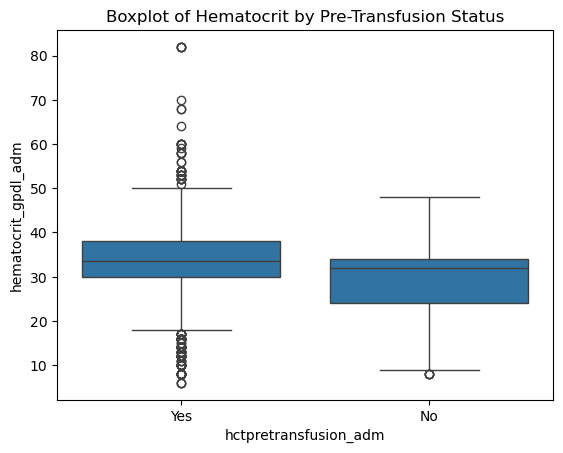

In [309]:
sns.boxplot(sepsis_df,x="hctpretransfusion_adm",y="hematocrit_gpdl_adm")
plt.title("Boxplot of Hematocrit by Pre-Transfusion Status")

In [310]:
# First, calculate mode (most frequent value)
mode_value = sepsis_df['hctpretransfusion_adm'].mode()[0]

# Define custom function
def impute_hctpretransfusion(row):
    if pd.isna(row['hctpretransfusion_adm']):
        if row['hematocrit_gpdl_adm'] < 10 or row['hematocrit_gpdl_adm'] > 50:
            return 'Yes'
        else:
            return mode_value
    else:
        return row['hctpretransfusion_adm']

# Apply the function to fill missing values
sepsis_df['hctpretransfusion_adm'] = sepsis_df.apply(impute_hctpretransfusion,axis=1)

* **"hctpretransfusion\_adm"** was imputed using a **distribution-based method** guided by a box plot analysis. Since the upper whisker for “No” responses was around 50 and the lower whisker around 10 (based on hematocrit values), missing entries with hematocrit values outside this range were classified as **"Yes"**. The remaining missing values were filled using the **mode**.

#### Imputing columns that do not need Logical Imputing with Mode

In [311]:
# List of categorical columns to exclude from imputation
exclude_cat_cols = ['bcseye_adm', 'bcsverbal_adm', 'hivstatus_adm', 'hctpretransfusion_adm']

# Select categorical columns with missing values
cat_cols_with_na = [col for col in sepsis_df.select_dtypes(include='object').columns 
                    if sepsis_df[col].isna().sum() > 0]

# Drop excluded columns
filtered_cat_cols = [col for col in cat_cols_with_na if col not in exclude_cat_cols]

# Impute remaining categorical columns with mode
for col in filtered_cat_cols:
    mode_val = sepsis_df[col].mode(dropna=True)[0]
    sepsis_df[col] = sepsis_df[col].fillna(mode_val)

### Checking for Missing Values after Imputation is done

In [312]:
sepsis_df.isnull().sum()

studyid_adm                      0
agecalc_adm                      0
height_cm_adm                    0
weight_kg_adm                    0
muac_mm_adm                      0
hr_bpm_adm                       0
rr_brpm_app_adm                  0
sysbp_mmhg_adm                   0
diasbp_mmhg_adm                  0
temp_c_adm                       0
spo2site1_pc_oxi_adm             0
spo2site2_pc_oxi_adm             0
momage_adm                       0
momagefirstpreg_adm              0
householdsize_adm                0
alivechildren_adm                0
deadchildren_adm                 0
hematocrit_gpdl_adm              0
lactate_mmolpl_adm               0
glucose_mmolpl_adm               0
sqi1_perc_oxi_adm                0
sqi2_perc_oxi_adm                0
sex_adm                          0
spo2onoxy_adm                    0
oxygenavail_adm                  0
respdistress_adm                 0
caprefill_adm                    0
bcseye_adm                       0
bcsmotor_adm        

* Observation : All columns do not contain missing value.

### Now we drop the columns that were added during the cleaning process

In [313]:
# sepsis_df.columns.get_loc('inhospital_mortality')
sepsis_df = sepsis_df.drop(sepsis_df.columns[113:], axis=1)

#### *Saving the Cleaned DataSet in a New CSV file*

In [314]:
# sepsis_df.to_csv("sepsis_cleaned.csv", index=False)

### Hypothesis Testing

To better understand which features are potentially associated with **in-hospital mortality**, we performed hypothesis testing for both **categorical** and **continuous** variables. This helps us identify variables that exhibit statistically significant differences between patients who **survived (0)** and those who **died (1)** during hospitalization.

---

#### Categorical Features – Chi-Square Test of Independence

This test evaluates whether there is a significant association between each categorical variable and the target outcome.

- **Null Hypothesis (H₀):** There is no association between the categorical feature and in-hospital mortality.  
- **Alternative Hypothesis (H₁):** There is a significant association between the categorical feature and in-hospital mortality.

---

#### Continuous Features – Mann-Whitney U Test

This non-parametric test is used to compare the distributions of two independent groups. It is preferred here due to the likely non-normal distribution of clinical measurements.

- **Null Hypothesis (H₀):** The distributions of the continuous variable are equal for survivors and non-survivors.  
- **Alternative Hypothesis (H₁):** The distributions of the continuous variable differ between survivors and non-survivors.

---

By identifying features with **low p-values** (typically **p < 0.01**), we can prioritize them in downstream modeling, as they may hold predictive value for mortality outcomes.



In [315]:
# Separate the target
target = 'inhospital_mortality'

# 1. Identify categorical and continuous features (excluding target)
categorical_features = sepsis_df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
continuous_features = sepsis_df.select_dtypes(include=['int64', 'float64']).drop(columns=[target]).columns.tolist()

# 2. Chi-square test for categorical features
print("\n--- Chi-Square Test Results ---")
for col in categorical_features:
    contingency_table = pd.crosstab(sepsis_df[col], sepsis_df[target])
    if contingency_table.shape[0] > 1:
        chi2, p, dof, _ = stats.chi2_contingency(contingency_table)
        print(f"{col}: p-value = {p:.4f}")

# 3. Mann-Whitney U Test for continuous features (non-parametric)
print("\n--- Mann-Whitney U Test Results ---")
for col in continuous_features:
    survived = sepsis_df[sepsis_df[target] == 0][col]
    died = sepsis_df[sepsis_df[target] == 1][col]
    u_stat, p_value = stats.mannwhitneyu(survived, died, alternative='two-sided')
    print(f"{col}: p-value = {p_value:.4f}")



--- Chi-Square Test Results ---
sex_adm: p-value = 0.5463
spo2onoxy_adm: p-value = 0.0000
oxygenavail_adm: p-value = 0.0000
respdistress_adm: p-value = 0.0002
caprefill_adm: p-value = 0.0064
bcseye_adm: p-value = 0.0000
bcsmotor_adm: p-value = 0.0000
bcsverbal_adm: p-value = 0.0000
bcgscar_adm: p-value = 0.0002
vaccmeasles_adm: p-value = 0.8093
vaccpneumoc_adm: p-value = 0.0492
vaccpneumocsource_adm: p-value = 0.9819
vaccdpt_adm: p-value = 0.0303
vaccdptsource_adm: p-value = 0.7855
priorweekabx_adm: p-value = 0.9838
priorweekantimal_adm: p-value = 0.7438
symptoms_adm___1: p-value = 0.8541
symptoms_adm___2: p-value = 0.0919
symptoms_adm___3: p-value = 0.0365
symptoms_adm___4: p-value = 0.1887
symptoms_adm___5: p-value = 0.9805
symptoms_adm___6: p-value = 0.7932
symptoms_adm___7: p-value = 0.3056
symptoms_adm___8: p-value = 0.6099
symptoms_adm___9: p-value = 0.6950
symptoms_adm___10: p-value = 0.7872
symptoms_adm___11: p-value = 0.7196
symptoms_adm___12: p-value = 0.5825
symptoms_adm___

#### Identifying Significant Columns based on p values

In [316]:
# 1. Separate categorical and continuous features
target = 'inhospital_mortality'
categorical_features = sepsis_df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
continuous_features = sepsis_df.select_dtypes(include=['int64', 'float64']).drop(columns=[target]).columns.tolist()

# 2. Chi-Square test for categorical features
significant_cat = []
for col in categorical_features:
    contingency = pd.crosstab(sepsis_df[col], sepsis_df[target])
    if contingency.shape[0] > 1:
        chi2, p, _, _ = stats.chi2_contingency(contingency)
        if p < 0.01:
            significant_cat.append(col)

# 3. Mann-Whitney U Test for continuous features
significant_cont = []
for col in continuous_features:
    group0 = sepsis_df[sepsis_df[target] == 0][col]
    group1 = sepsis_df[sepsis_df[target] == 1][col]
    try:
        u_stat, p_value = stats.mannwhitneyu(group0, group1, alternative='two-sided')
        if p_value < 0.01:
            significant_cont.append(col)
    except:
        pass  # Skip if error due to too many NaNs or invalid inputs

# 4. Combine and review
significant_features = significant_cat + significant_cont
print(f"Total insignificant features (p < 0.01): {len(significant_features)}")
print(significant_features)

Total insignificant features (p < 0.01): 20
['spo2onoxy_adm', 'oxygenavail_adm', 'respdistress_adm', 'caprefill_adm', 'bcseye_adm', 'bcsmotor_adm', 'bcsverbal_adm', 'bcgscar_adm', 'symptoms_adm___14', 'symptoms_adm___15', 'diarrheaoften_adm', 'feedingstatus_adm', 'totalbreastfed_adm', 'caregivermarried_adm', 'waterpure_adm', 'bednet_adm', 'hctpretransfusion_adm', 'weight_kg_adm', 'muac_mm_adm', 'lactate_mmolpl_adm']



* After applying the Chi Square and Mann-Whitney U Test the following columns appeared as significant columns:

*Categorical Variables*
- 'spo2onoxy_adm'
- 'oxygenavail_adm'
- 'respdistress_adm'
- 'caprefill_adm'
- 'bcseye_adm'
- 'bcsmotor_adm'
- 'bcsverbal_adm'
- 'bcgscar_adm'
- 'symptoms_adm___14'
- 'symptoms_adm___15'
- 'diarrheaoften_adm'
- 'feedingstatus_adm'
- 'totalbreastfed_adm'
- 'caregivermarried_adm'
- 'waterpure_adm'
- 'bednet_adm'
- 'hctpretransfusion_adm'

 *Numerical Variables*
- 'weight_kg_adm'
- 'muac_mm_adm'
- 'lactate_mmolpl_adm'


___
## Exploratory Data Analysis
___

___
### 1. Demographic Analysis
___

### *Distribution of age(in years)*

Text(0, 0.5, 'Frequency')

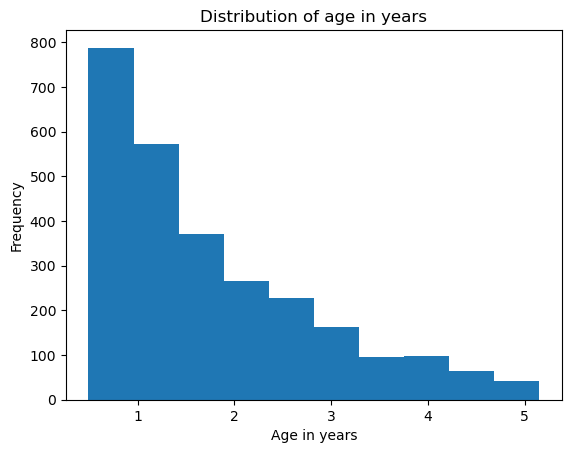

In [317]:
plt.hist(sepsis_df["agecalc_adm"]/12)
plt.title("Distribution of age in years")
plt.xlabel("Age in years")
plt.ylabel("Frequency")

___
The plot displays a histogram showing the distribution of patient ages at admission, measured in years (`agecalc_adm`). The x-axis represents the age in years, and the y-axis represents the frequency or count of patients within each age bin.

The histogram reveals a strong left-skewed distribution, indicating that the majority of patients admitted are in the younger age ranges.

* The highest frequency of patients falls within the first bin, representing children likely under or around 1 year old.
* The frequency of patients decreases steadily as age increases. Each subsequent age group has a progressively smaller number of patients compared to the preceding younger age group.
* There are relatively few patients in the older age ranges depicted in the histogram (e.g., 4-5 years).

In summary, the distribution of age at admission shows that the patient population is predominantly composed of younger children, with the number of admissions decreasing significantly with increasing age within the displayed range. This suggests that the study population might be focused on infants and very young children.___

### *Gender Distribution*

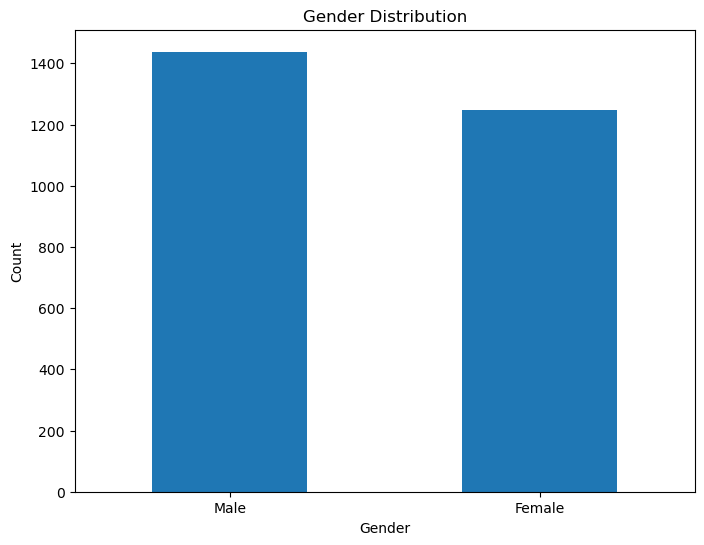

In [318]:
gender_counts = sepsis_df['sex_adm'].value_counts()
plt.figure(figsize=(8, 6))
gender_counts.plot(kind='bar')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

___
The plot displays a bar chart illustrating the gender distribution of the patients at admission, based on the variable `sex_adm` as described in the data dictionary. The x-axis represents the gender categories ("Male" and "Female"), and the y-axis represents the count or frequency of patients within each category.

The bar chart shows the following:

* The bar representing "Male" patients is taller than the bar representing "Female" patients.
* The approximate count of male patients is around 1450.
* The approximate count of female patients is around 1250.

In summary, the gender distribution at admission indicates a slightly higher number of male patients compared to female patients within this dataset.
___

### *Vaccination Status*

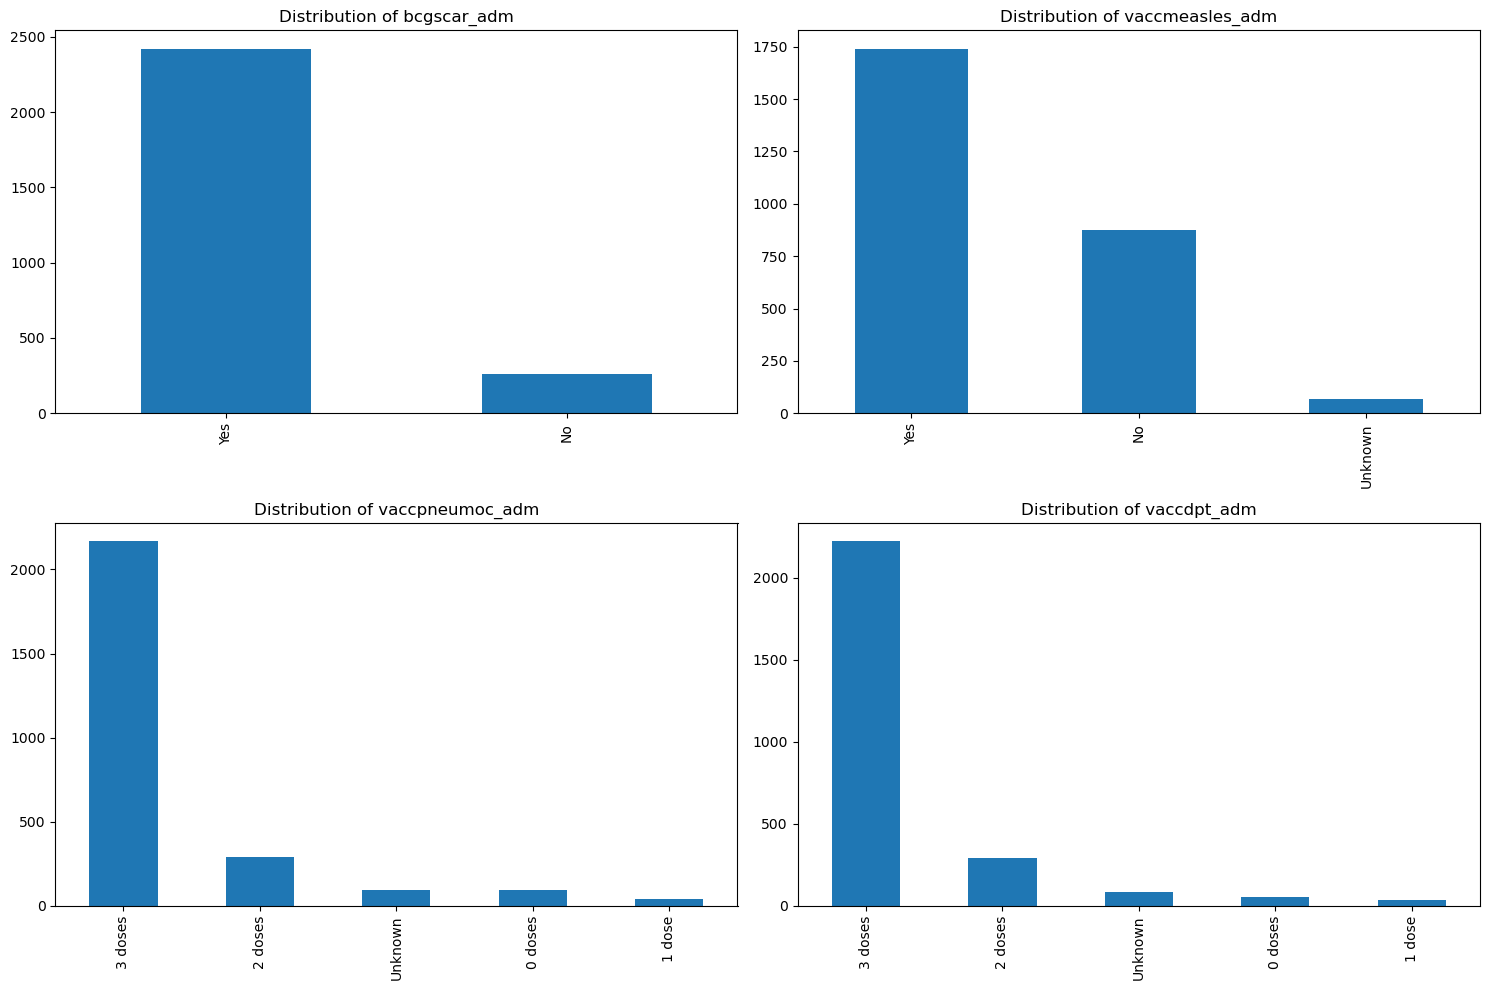

In [319]:
vacc_cols = ['bcgscar_adm', 'vaccmeasles_adm', 'vaccpneumoc_adm', 'vaccdpt_adm']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for col, ax in zip(vacc_cols, axes.flatten()):
    sepsis_df[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('')
plt.tight_layout()
plt.show()

___
The plot displays the distribution of four categorical variables related to vaccination status at admission: `bcgscar_adm`, `vaccmeasles_adm`, `vaccpneumoc_adm`, and `vaccdpt_adm`.

* **`bcgscar_adm`**: The vast majority of patients have a BCG scar ("Yes"), while a small proportion do not ("No").

* **`vaccmeasles_adm`**: Most patients have received the measles vaccine ("Yes"), with a notable number having not received it ("No") and a very small number with unknown status ("Unknown").

* **`vaccpneumoc_adm`**: The majority of patients have received 3 doses of the pneumococcal vaccine. Smaller proportions have received 2 doses, 0 doses, 1 dose, or have an unknown vaccination status.

* **`vaccdpt_adm`**: Similar to the pneumococcal vaccine, most patients have received 3 doses of the DPT vaccine. Smaller proportions have received 2 doses, 0 doses, 1 dose, or have an unknown vaccination status.

In summary, the plots indicate generally high rates of BCG and measles vaccination in this patient population. For pneumococcal and DPT vaccines, a significant portion has received the full 3-dose series, but there are also smaller groups with incomplete or unknown vaccination histories.
___

### 2.Clinical Vital Signs Analysis

### *Vital signs distributions*


=== Clinical Vital Signs Analysis ===


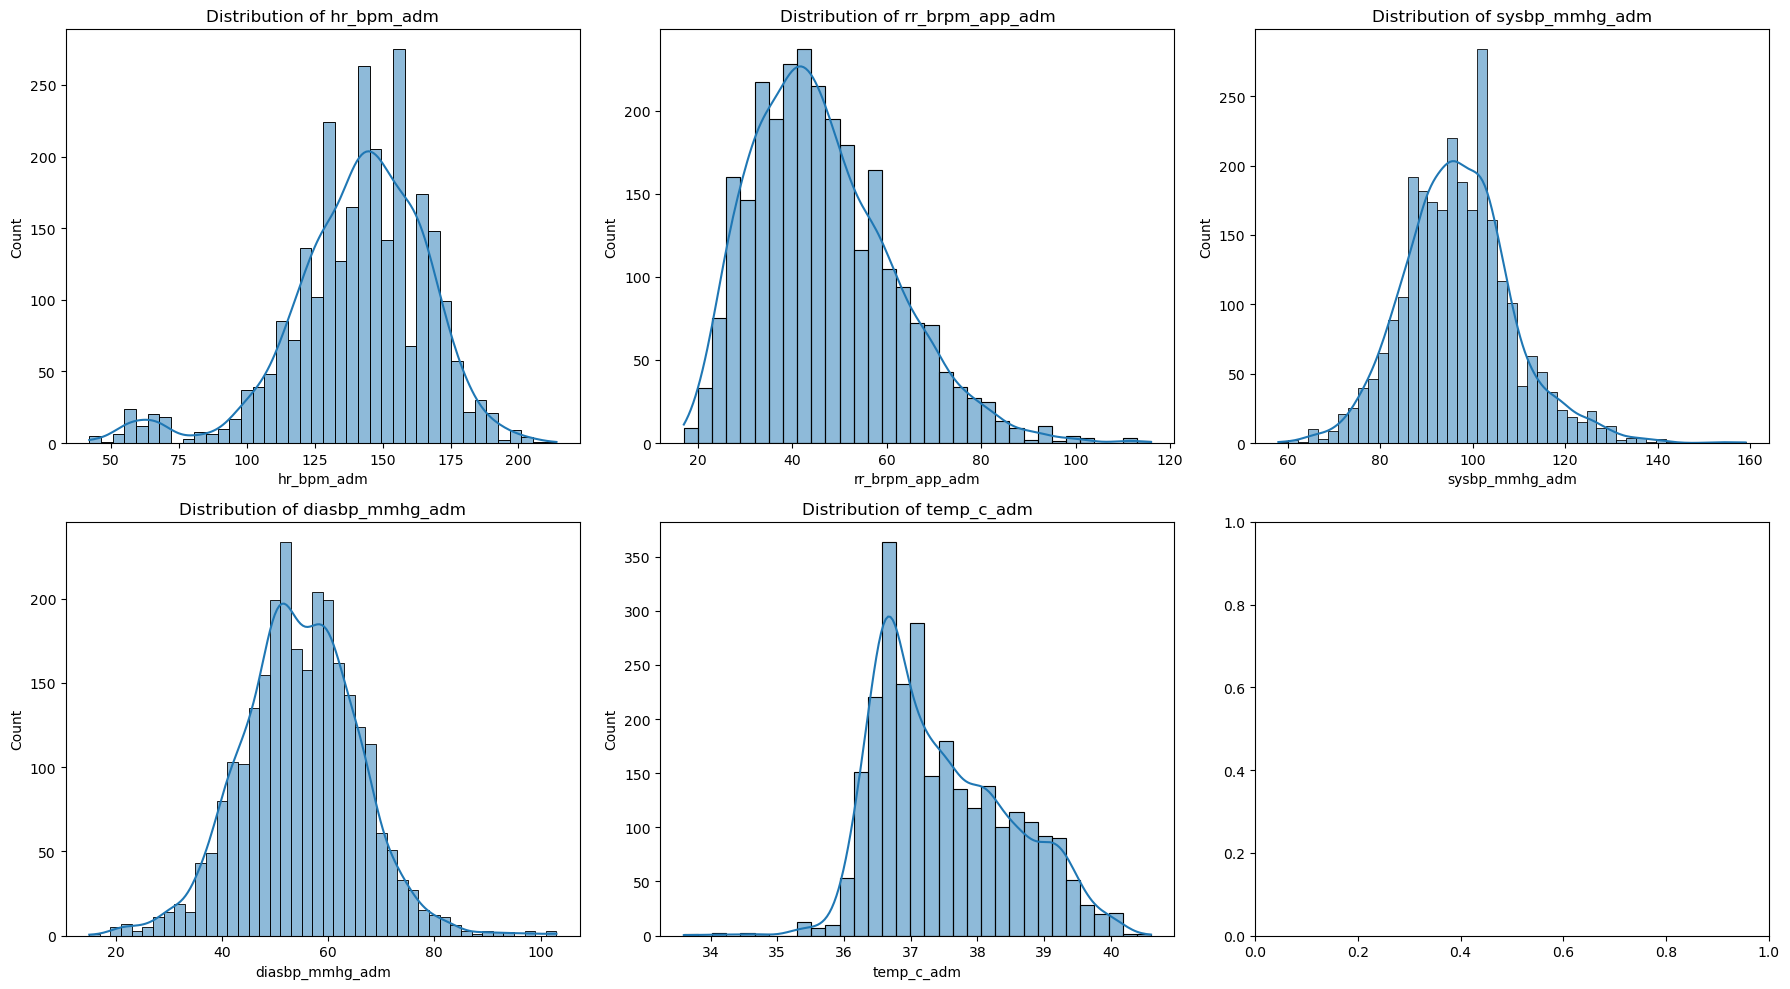

In [320]:
def clinical_analysis(sepsis_df):
    print("\n=== Clinical Vital Signs Analysis ===")
    
    # Vital signs distributions
    vital_signs = ['hr_bpm_adm', 'rr_brpm_app_adm', 'sysbp_mmhg_adm', 'diasbp_mmhg_adm', 'temp_c_adm']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    for i, col in enumerate(vital_signs):
        sns.histplot(sepsis_df[col], kde=True, ax=axes[i//3, i%3])
        axes[i//3, i%3].set_title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()
clinical_analysis(sepsis_df)

___
The plot displays the distribution of five continuous vital sign variables recorded at admission: heart rate (`hr_bpm_adm`), respiratory rate (`rr_brpm_app_adm`), systolic blood pressure (`sysbp_mmhg_adm`), diastolic blood pressure (`diasp_mmhg_adm`), and temperature (`temp_c_adm`). Each variable's distribution is visualized using a histogram with a kernel density estimate (KDE) overlay.

* **`hr_bpm_adm` (Heart Rate):** The distribution appears somewhat bimodal, with a primary peak around 140-160 beats per minute and a smaller peak around 60-80 bpm. This suggests the presence of two distinct groups within the patient population regarding heart rate at admission.

* **`rr_brpm_app_adm` (Respiratory Rate):** The distribution is right-skewed, with a primary peak around 30-40 breaths per minute. This indicates that most patients had a higher respiratory rate at admission, with fewer patients exhibiting lower rates.

* **`sysbp_mmhg_adm` (Systolic Blood Pressure):** The distribution is approximately normal, centered around 90-100 mmHg. There's a noticeable peak in this range, indicating that a large proportion of patients had systolic blood pressure values within this range at admission.

* **`diasp_mmhg_adm` (Diastolic Blood Pressure):** Similar to systolic blood pressure, the distribution is roughly normal and centered around 50-60 mmHg. A clear peak is observed in this range, suggesting a common diastolic blood pressure level among the admitted patients.

* **`temp_c_adm` (Temperature):** The distribution is left-skewed, with a primary peak around 36.5-37.5 degrees Celsius. This suggests that most patients had a relatively normal temperature at admission, with fewer patients presenting with higher temperatures (fever).

In summary, the distributions of these vital signs at admission reveal varying patterns. Heart rate shows potential subgroups, respiratory rate indicates a tendency towards higher values, blood pressure measurements appear normally distributed around specific ranges, and temperature suggests a predominantly normothermic population with fewer cases of fever. These initial distributions can provide insights into the physiological state of the patients upon admission.
___

### *Correlation heatmap*

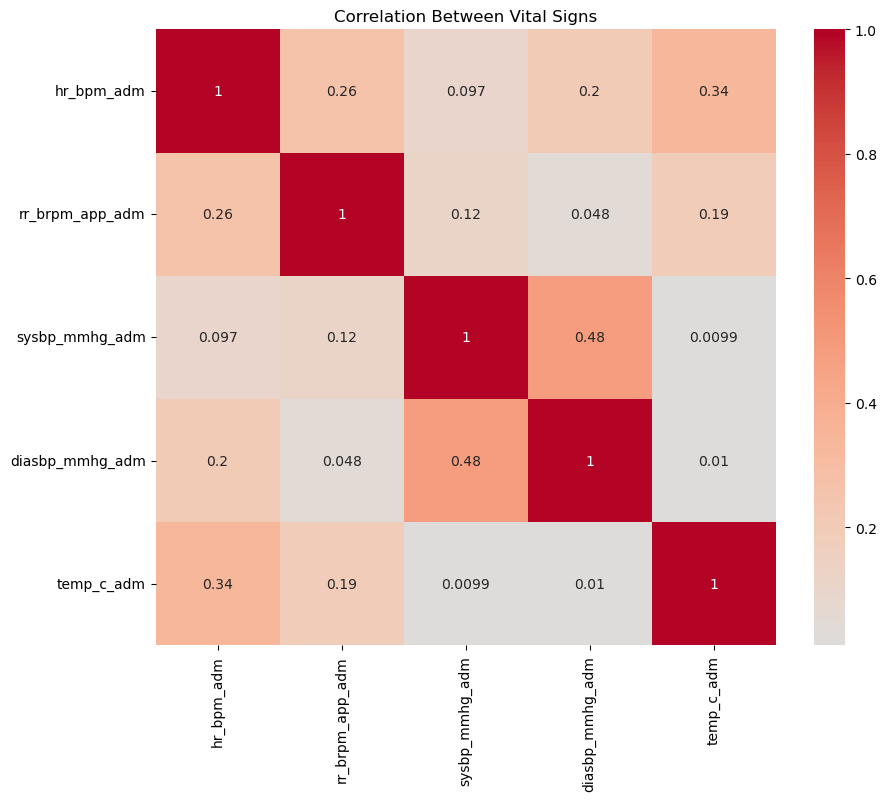

In [321]:
plt.figure(figsize=(10, 8))
vital_signs = ['hr_bpm_adm', 'rr_brpm_app_adm', 'sysbp_mmhg_adm', 'diasbp_mmhg_adm', 'temp_c_adm']
corr_matrix = sepsis_df[vital_signs].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Vital Signs')
plt.show()

The first plot displays a heatmap showing the pairwise correlations between five continuous vital sign variables recorded at admission: heart rate (`hr_bpm_adm`), respiratory rate (`rr_brpm_app_adm`), systolic blood pressure (`sysbp_mmhg_adm`), diastolic blood pressure (`diasp_mmhg_adm`), and temperature (`temp_c_adm`). The color intensity and the numerical values within each cell represent the strength and direction of the linear correlation between the corresponding pair of variables. The color scale ranges from light (indicating weak or no correlation) to dark red (indicating strong positive correlation).

Key observations from the correlation heatmap:

* **Diagonal:** The diagonal cells show a perfect positive correlation of 1, as each variable is perfectly correlated with itself.

* **Heart Rate (`hr_bpm_adm`)**:
    * Shows a weak positive correlation (0.26) with respiratory rate (`rr_brpm_app_adm`).
    * Shows a very weak positive correlation (0.097) with systolic blood pressure (`sysbp_mmhg_adm`).
    * Shows a weak positive correlation (0.20) with diastolic blood pressure (`diasp_mmhg_adm`).
    * Shows a moderate positive correlation (0.34) with temperature (`temp_c_adm`).

* **Respiratory Rate (`rr_brpm_app_adm`)**:
    * Shows a weak positive correlation (0.12) with systolic blood pressure (`sysbp_mmhg_adm`).
    * Shows a very weak positive correlation (0.048) with diastolic blood pressure (`diasp_mmhg_adm`).
    * Shows a weak positive correlation (0.19) with temperature (`temp_c_adm`).

* **Systolic Blood Pressure (`sysbp_mmhg_adm`)**:
    * Shows a moderate positive correlation (0.48) with diastolic blood pressure (`diasp_mmhg_adm`).
    * Shows a very weak positive correlation (0.0099) with temperature (`temp_c_adm`), indicating almost no linear relationship.

* **Diastolic Blood Pressure (`diasp_mmhg_adm`)**:
    * Shows a very weak positive correlation (0.01) with temperature (`temp_c_adm`), indicating almost no linear relationship.

In summary, the correlation analysis reveals mostly weak to moderate positive linear relationships between these vital signs. The strongest positive correlation is observed between systolic and diastolic blood pressure, which is expected. Heart rate shows a moderate positive correlation with temperature, and weak positive correlations with respiratory rate and blood pressure. The correlations involving temperature with blood pressure are very weak. These findings suggest that while some vital signs tend to increase or decrease together to a certain extent, they also have a degree of independent variability within this patient population at admission.

### *Oxygen status*

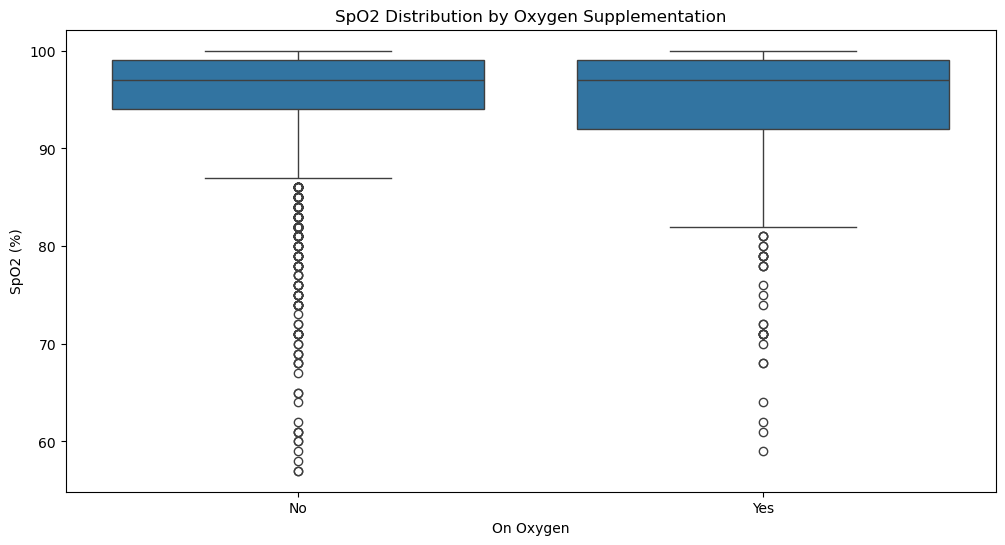

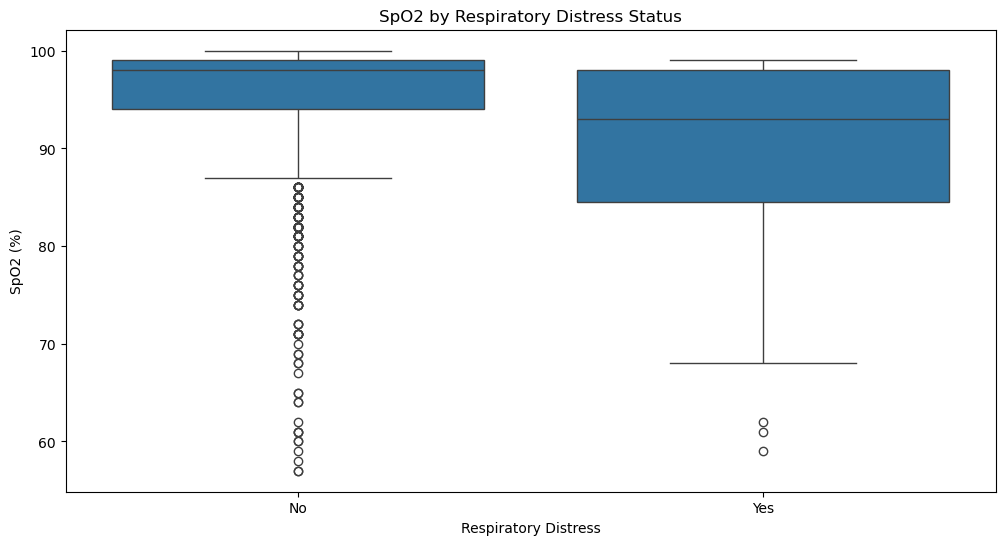

In [322]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=sepsis_df, x='spo2onoxy_adm', y='spo2site1_pc_oxi_adm')
plt.title('SpO2 Distribution by Oxygen Supplementation')
plt.xlabel('On Oxygen')
plt.ylabel('SpO2 (%)')
plt.show()
    
plt.figure(figsize=(12, 6))
sns.boxplot(data=sepsis_df, x='respdistress_adm', y='spo2site1_pc_oxi_adm')
plt.title('SpO2 by Respiratory Distress Status')
plt.xlabel('Respiratory Distress')
plt.ylabel('SpO2 (%)')
plt.show()

___
The first plot displays two box plots comparing the distribution of oxygen saturation levels (`spo2onoxy_adm`) at admission based on whether the patient was on oxygen supplementation (`oxygenavail_adm`). The x-axis represents the oxygen availability, where '0' likely indicates oxygen was not available or in use, and '1' indicates oxygen was available and presumably in use. The y-axis represents the oxygen saturation percentage (Spo2 (%)).

For patients where oxygen was not available or in use (0):

* The median Spo2 is around 97-98%.
* The interquartile range (IQR), representing the middle 50% of the data, spans from approximately 95% to just below 100%.
* The whiskers extend down to around 87%, indicating the spread of the majority of the data.
* Several outliers are present below the lower whisker, indicating some patients in this group had significantly lower oxygen saturation levels.

For patients where oxygen was available (1):

* The median Spo2 is slightly lower than the group not on oxygen, around 96-97%.
* The IQR extends from approximately 93% to 99%.
* The lower whisker extends down to around 82%.
* A larger number of outliers are present below the lower whisker compared to the group not on oxygen, indicating a wider range and more instances of lower oxygen saturation levels in patients for whom oxygen was available.

In summary, the box plots suggest that while the central tendency of oxygen saturation is high in both groups, patients for whom oxygen was available at admission tend to have a slightly lower median Spo2 and a greater spread of lower values, as evidenced by the longer lower whisker and the increased number of outliers. This implies that oxygen supplementation was likely provided to patients with lower oxygen saturation levels.
___

___
The second plot displays two box plots comparing the distribution of oxygen saturation levels (`spo2onoxy_adm`) at admission based on the presence or absence of respiratory distress (`respidistress_adm`). The x-axis represents the respiratory distress status, where '0' likely indicates the absence of respiratory distress, and '1' indicates the presence of respiratory distress. The y-axis represents the oxygen saturation percentage (Spo2 (%)).

For patients without respiratory distress (0):

* The median Spo2 is high, around 98%.
* The interquartile range (IQR) spans from approximately 95% to just below 100%.
* The lower whisker extends down to around 87%.
* Several outliers are present below the lower whisker, indicating some patients without reported respiratory distress still had lower oxygen saturation levels.

For patients with respiratory distress (1):

* The median Spo2 is notably lower, around 94%.
* The IQR is wider, ranging from approximately 85% to 98%.
* The lower whisker extends down to around 68%.
* There are fewer outliers at the lower end compared to the non-respiratory distress group, but the overall distribution is shifted towards lower Spo2 values.

In summary, the box plots clearly show that patients with respiratory distress at admission tend to have significantly lower oxygen saturation levels compared to those without respiratory distress. The median Spo2 is lower, and the distribution for the respiratory distress group is shifted towards lower values, indicating a compromised respiratory function in this subgroup.
___

### *Neurological assessment*

In [323]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

neuro_cols = ['bcseye_adm', 'bcsmotor_adm', 'bcsverbal_adm']
fig = make_subplots(rows=1, cols=3, subplot_titles=neuro_cols)

# Use a consistent color palette
color_sequence = px.colors.qualitative.Pastel

# Track which legend items have been added
added_legend_items = set()

for i, col in enumerate(neuro_cols):
    ct = pd.crosstab(sepsis_df['inhospital_mortality'], sepsis_df[col], normalize='index') * 100
    ct = ct.reset_index().melt(id_vars='inhospital_mortality', var_name=col, value_name='Percentage')
    ct['inhospital_mortality'] = ct['inhospital_mortality'].map({0: 'Survived', 1: 'Died'})

    fig_part = px.bar(
        ct,
        x='inhospital_mortality',
        y='Percentage',
        color=col,
        barmode='stack',
        color_discrete_sequence=color_sequence,
    )

    for trace in fig_part.data:
        # Show legend only if not already added
        if trace.name not in added_legend_items:
            trace.showlegend = True
            added_legend_items.add(trace.name)
        else:
            trace.showlegend = False
        fig.add_trace(trace, row=1, col=i+1)

fig.update_layout(
    height=500,
    width=1200,
    title_text="Neurological Columns by Mortality",
    yaxis_title='Percentage (%)',
    legend_title_text="Score",
    legend=dict(traceorder="normal")
)

fig.show()


___
The plot displays three stacked bar charts illustrating the distribution of different components of the Best Coma Scale (BCS) at admission (`bcseye_adm`, `bcsmotor_adm`, `bcsverbal_adm`) as a percentage, stratified by in-hospital mortality ("Survived" and "Died"). Each bar represents 100% of the patients within the respective mortality group, and the segments within each bar show the proportion of patients falling into different categories of each BCS component.

**Chart 1: `bcseye_adm` Distribution by Mortality (Eye Opening)**

* **Survived:** The vast majority of survivors (nearly 100%) had the best eye-opening response ("Watches or follows"). A very small percentage ("Fails to watch or follow").
* **Died:** A smaller proportion of patients who died ("Watches or follows") compared to survivors. A substantial portion ("Fails to watch or follow").
* **Interpretation:** Good eye-opening response is strongly associated with survival. Impaired eye-opening is more prevalent in non-survivors.

**Chart 2: `bcsmotor_adm` Distribution by Mortality (Motor Response)**

* **Survived:** The largest proportion of survivors "Localizes painful stimulus". A smaller but significant proportion "Withdraws limb from painful stimulus", and a small percentage show "No response or inappropriate response".
* **Died:** A much larger proportion of non-survivors show "No response or inappropriate response" compared to survivors. The proportion of patients who "Localizes painful stimulus" or "Withdraws limb from painful stimulus" is lower in the "Died" group.
* **Interpretation:** Better motor responses to pain are strongly linked to survival. Lack of or inappropriate motor response is much more common in non-survivors.

**Chart 3: `bcsverbal_adm` Distribution by Mortality (Verbal Response)**

* **Survived:** The dominant verbal response among survivors is "Cries appropriately with pain, or, if verbal, speaks". Smaller proportions show "Moan or abnormal cry with pain" and "No vocal response to pain".
* **Died:** A very large proportion of non-survivors show "No vocal response to pain". The proportions of patients with "Cries appropriately with pain, or, if verbal, speaks" and "Moan or abnormal cry with pain" are significantly lower in the "Died" group.
* **Interpretation:** Good verbal response is a strong indicator of survival. Absence of vocal response is highly associated with mortality.

**Overall Interpretation:**

These proportional stacked bar charts reinforce the findings from the count-based bar charts. They clearly demonstrate that better neurological function, as indicated by higher scores on all three components of the Best Coma Scale at admission, is strongly associated with a higher survival rate. Conversely, lower neurological scores, indicating more severe neurological impairment, are significantly more common in patients who did not survive their hospital stay. The differences in the proportions of each BCS category between the "Survived" and "Died" groups highlight the prognostic value of the initial neurological assessment.
___

___
### *Symptoms Analysis*
___

___
        'symptoms_adm_1': 'Rash',
        'symptoms_adm_2': 'Cough <14 Days',
        'symptoms_adm_3': 'Cough >14 Days',
        'symptoms_adm_4': 'Diarrhea <14 Days',
        'symptoms_adm_5': 'Diarrhea >14 Days',
        'symptoms_adm_6': 'Fever/Hotness <7 Days',
        'symptoms_adm_7': 'Fever/Hotness >7 Days',
        'symptoms_adm_8': 'Vomiting Everything',
        'symptoms_adm_9': 'Abnormally Sleepy',
        'symptoms_adm_10': 'Swelling of Both Feet',
        'symptoms_adm_11': 'Changes in Urine Color',
        'symptoms_adm_12': 'Making Less Urine',
        'symptoms_adm_13': 'Blood in Stool',
        'symptoms_adm_14': 'Seizures/Convulsions',
        'symptoms_adm_15': 'Coma',
        'symptoms_adm_16': 'Yellow Soles (<2mo)',
___
        


In [324]:
import plotly.express as px

def interactive_symptoms_analysis(df):
    # Get all symptom columns
    symptom_cols = [col for col in df.columns if col.startswith('symptoms_adm_')]
    
    # Convert Checked/Unchecked to 1/0
    symptom_df = df[symptom_cols].apply(lambda x: x.map({'Checked': 1, 'Unchecked': 0}))
    symptom_df['Mortality'] = df['inhospital_mortality'].map({0: 'Survived', 1: 'Died'})
    
    # Melt for plotting
    melted_df = symptom_df.melt(id_vars='Mortality', var_name='Symptom', value_name='Present')
    
    # Clean symptom names
    melted_df['Symptom'] = melted_df['Symptom'].str.replace('symptoms_adm_', '')
    
    # Create interactive plot
    fig = px.bar(melted_df.groupby(['Mortality', 'Symptom'])['Present'].mean().reset_index(),
                 x='Present', y='Symptom', color='Mortality',
                 barmode='group',
                 title='Symptom Prevalence by Mortality Status',
                 labels={'Present': 'Proportion of Patients'},
                 color_discrete_map={'Survived': 'skyblue', 'Died': 'salmon'},
                 height=600)
    
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    fig.show()
interactive_symptoms_analysis(sepsis_df)

### Interpretation of Symptom Prevalence by Mortality Status

### Overview
This graph shows the proportion of patients experiencing different symptoms, split by mortality status (whether patients survived or died). The horizontal bars represent the prevalence of each symptom, with red bars indicating prevalence among patients who died and blue bars showing prevalence among those who survived.

### Key Findings

#### Highest Prevalence Symptoms
- **Symptom _6** has the highest overall prevalence, appearing in approximately 80% of patients who died and about 75% of patients who survived.
- **Symptom _2** is also highly prevalent, appearing in roughly 61% of patients who died and 69% of patients who survived.

### Mortality Indicators
- Several symptoms appear to be more prevalent in patients who died compared to those who survived: 
  - **Symptom _15**: Present almost exclusively in patients who died, with minimal occurrence in survivors
  - **Symptom _14**: Significantly higher in those who died
  - **Symptom _3**: higher in those who died
  - **Symptom _7 , 10, & 6**: slightly higher in those who died

### Survival Indicators
- Some symptoms were more common in patients who survived:
  - **Symptom _2**: Higher prevalence in survivors
  - **Symptom _4**: Slightly higher in survivors
  - **Symptom _12 ,1 ,8, 9 ,**:  they appear more frequently in survivors


### Clinical Implications
The disparities in symptom prevalence between mortality groups could be valuable for clinical assessment and prognosis. Symptoms with large differences between the groups (such as _15 and _14) might be important warning signs that warrant closer monitoring or more aggressive intervention.


### Conclusion
This visualization effectively highlights which symptoms are associated with higher mortality, which could help clinicians prioritize their attention to specific symptoms during patient assessment. Symptoms _6 and _2 appear to be common baseline symptoms of the condition being studied, while symptoms showing large disparities between mortality groups may have prognostic value.

___
### Comorbodity Analysis
___

In [325]:
import pandas as pd
import plotly.express as px

# Melt the dataframe to long format
comorbidity_df = sepsis_df.melt(
    id_vars='inhospital_mortality',
    value_vars=['comorbidity_adm___10', 'comorbidity_adm___11', 'comorbidity_adm___12'],
    var_name='Comorbidity',
    value_name='Presence'  # 1 = present, 0 = absent
)

# Plot the grouped histogram
fig = px.histogram(comorbidity_df, x='Comorbidity', color='inhospital_mortality', barmode='group',
                   title='Survival Status by Comorbidities',
                   labels={'inhospital_mortality': 'Outcome', 'Comorbidity': 'Comorbidity Type'})
fig.update_layout(legend_title_text='Patient Status')
fig.show()

In [326]:

# Calculate counts for each comorbidity and in-hospital mortality combination
comorbidity_counts = comorbidity_df.groupby(['Comorbidity', 'Presence', 'inhospital_mortality']).size().reset_index(name='count')

# Format the report for each comorbidity
for comorbidity in ['comorbidity_adm___10', 'comorbidity_adm___11', 'comorbidity_adm___12']:
    print(f"### {comorbidity} Analysis")
    comorbidity_data = comorbidity_counts[comorbidity_counts['Comorbidity'] == comorbidity]
    print(comorbidity_data.to_string(index=False))
    print("\n")


### comorbidity_adm___10 Analysis
         Comorbidity  Presence  inhospital_mortality  count
comorbidity_adm___10   Checked                     0     11
comorbidity_adm___10   Checked                     1      3
comorbidity_adm___10 Unchecked                     0   2556
comorbidity_adm___10 Unchecked                     1    116


### comorbidity_adm___11 Analysis
         Comorbidity  Presence  inhospital_mortality  count
comorbidity_adm___11   Checked                     0   2285
comorbidity_adm___11   Checked                     1    101
comorbidity_adm___11 Unchecked                     0    282
comorbidity_adm___11 Unchecked                     1     18


### comorbidity_adm___12 Analysis
         Comorbidity  Presence  inhospital_mortality  count
comorbidity_adm___12   Checked                     0     68
comorbidity_adm___12   Checked                     1      5
comorbidity_adm___12 Unchecked                     0   2499
comorbidity_adm___12 Unchecked                     1  

### 1. For Patients with "Other Co-Morbidity" (comorbidity_adm___10 = yes):

- Survived: 2556
- Died: 116

    - Total Patients: 2556 + 116 = 2672
    - To calculate the survival percentage:

Survival Rate = (Survived Total Patients) × 100
Survival Rate=(Total Patients Survived)×100
Survival Rate= (2556/2672)×100 = 95.65%
Survival Rate=(2672/2556)×100=95.65%

- So, the survival rate among patients with "Other Co-Morbidity" is approximately 95.65%.

### 2. For Patients without "Other Co-Morbidity" (comorbidity_adm___10 = no):

- Survived: 11
- Died: 3

  - Total Patients: 11 + 3 = 14
  - To calculate the survival percentage:

Survival Rate = (Survived Total Patients) × 100
Survival Rate=(Total Patients Survived)×100
Survival Rate= 11/14)×100 = 78.57%

- So, the survival rate among patients without "Other Co-Morbidity" is approximately 78.57%.

Summary:
Patients with "Other Co-Morbidity": 95.65% survival rate

Patients without "Other Co-Morbidity": 78.57% survival rate

* The survival rate is significantly higher for those with "Other Co-Morbidity", although it's important to remember that this group represents less than 1% of the total population, so the generalizability of this comparison is limited.

### 3. For comorbidity_adm___11 (None):
*  Patients with "comorbidity_adm___11": 94% survival rate
* Patients without "comorbidity_adm___11": 95.77% survival rate

### 4. For comorbidity_adm___12 (Unknown):
* Patients with "comorbidity_adm___12": 95.66% survival rate
* Patients without "comorbidity_adm___12": 93.15% survival rate

___
## Comparing vital signs between survivors and non-survivors
___

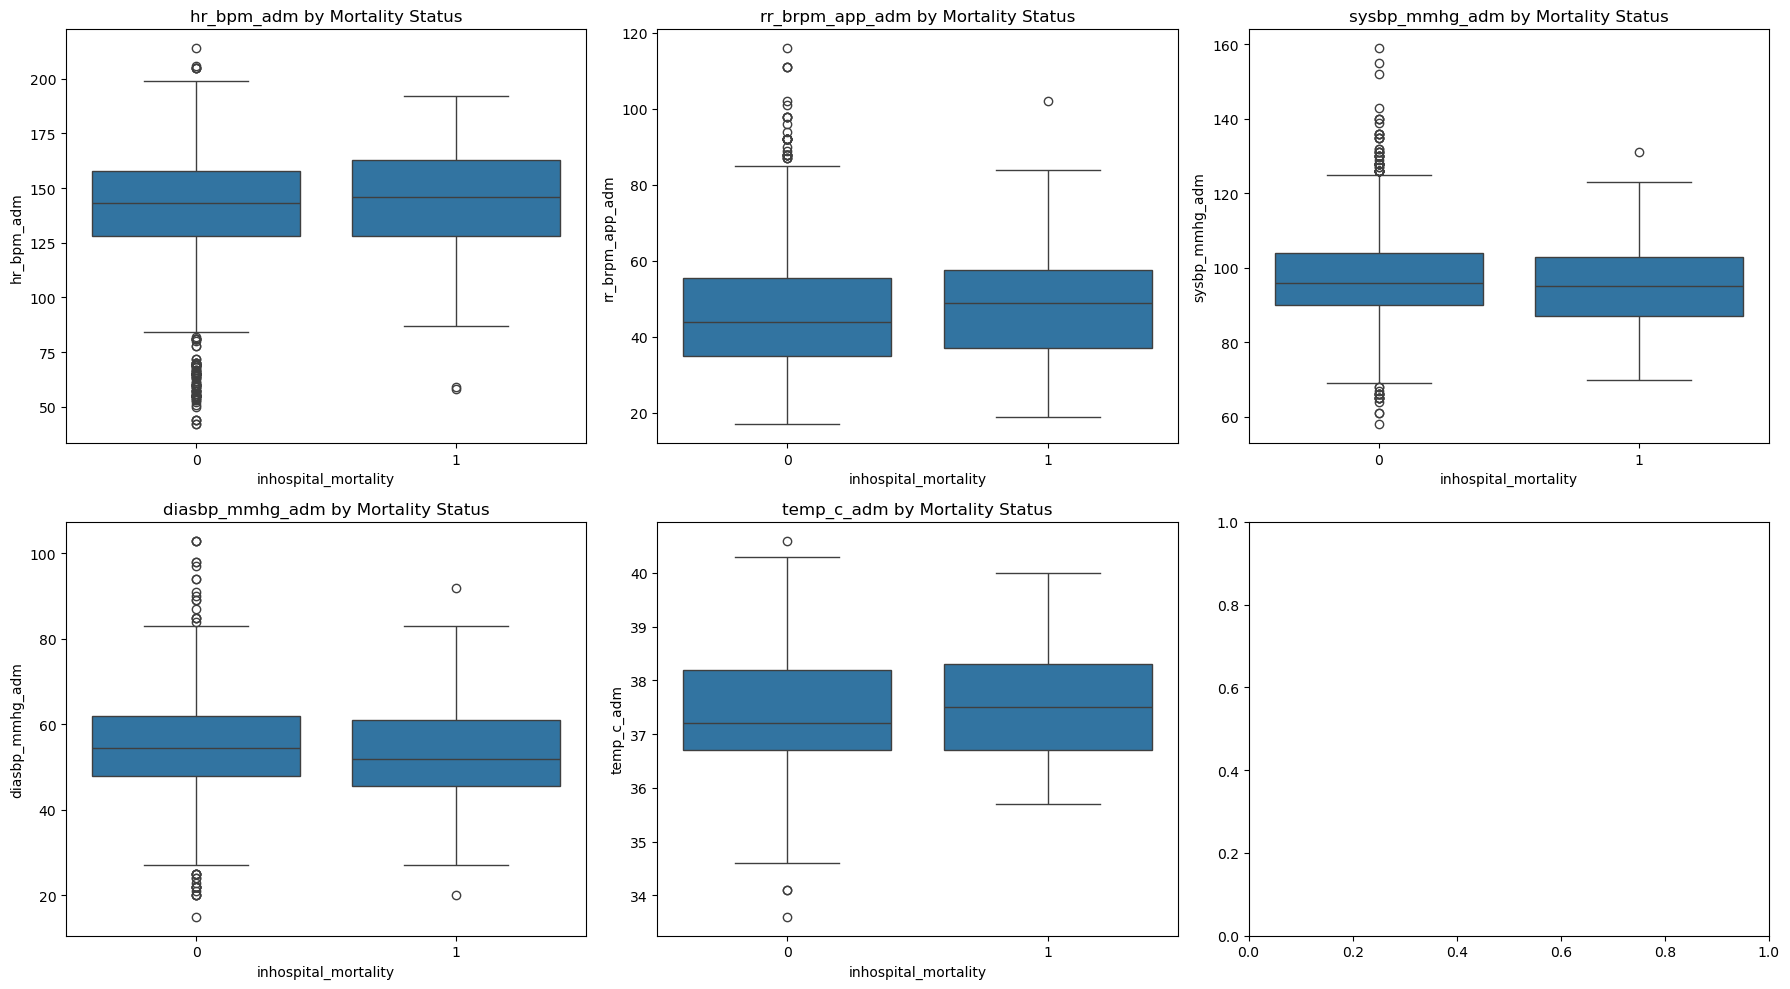

In [327]:
# Compare vital signs between survivors and non-survivors
vital_signs = ['hr_bpm_adm', 'rr_brpm_app_adm', 'sysbp_mmhg_adm', 'diasbp_mmhg_adm', 'temp_c_adm']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, col in enumerate(vital_signs):
    sns.boxplot(data=sepsis_df, x='inhospital_mortality', y=col, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'{col} by Mortality Status')
plt.tight_layout()
plt.show()

In [328]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

vital_signs = ['hr_bpm_adm', 'rr_brpm_app_adm', 'sysbp_mmhg_adm', 'diasbp_mmhg_adm', 'temp_c_adm']
mortality_map = {0: 'Survived', 1: 'Died'}

# Create a 2x3 subplot layout
fig = make_subplots(rows=2, cols=3, subplot_titles=vital_signs)

for i, col in enumerate(vital_signs):
    row, col_num = (i // 3) + 1, (i % 3) + 1
    for status, label in mortality_map.items():
        fig.add_trace(
            go.Box(
                y=sepsis_df[sepsis_df['inhospital_mortality'] == status][col],
                name=label,
                boxmean='sd',
                marker_color='blue' if status == 0 else 'red',
                legendgroup=label,
                showlegend=(i == 0)  # show legend only once
            ),
            row=row,
            col=col_num
        )

fig.update_layout(
    height=600,
    width=1100,
    title_text='Vital Signs by Mortality Status',
    showlegend=True
)

fig.show()


In [329]:
from scipy.stats import pointbiserialr

# Define variables
vital_signs = ['hr_bpm_adm', 'rr_brpm_app_adm', 'sysbp_mmhg_adm', 'diasbp_mmhg_adm', 'temp_c_adm']
target = 'inhospital_mortality'

# Calculate correlations
correlations = {}
for vs in vital_signs:
    valid_data = sepsis_df[[vs, target]].dropna()
    if len(valid_data) > 10:  # Minimum sample size threshold
        corr = pointbiserialr(valid_data[vs], valid_data[target])[0]  # Get only correlation coefficient
        correlations[vs] = corr

# Create and display results
results = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
results = results.sort_values('Correlation', key=abs, ascending=False)

# Print clean results
print("Vital Sign Correlations with Mortality:")
print("--------------------------------------")
print(results.to_string(float_format="%.2f"))

Vital Sign Correlations with Mortality:
--------------------------------------
                 Correlation
rr_brpm_app_adm         0.03
temp_c_adm              0.03
sysbp_mmhg_adm         -0.03
diasbp_mmhg_adm        -0.03
hr_bpm_adm              0.02


# Analysis of Vital Signs by Mortality Status in Pediatric Sepsis Cases

## Overview
This analysis examines the relationship between vital signs at admission and mortality outcomes in pediatric sepsis cases. The dataset consists of patients who met sepsis criteria, with all cases assumed to be septic. The plots compare vital signs between survivors and non-survivors, highlighting deviations from normal ranges and the impact of medical interventions.

## Key Observations

### 1. Heart Rate (hr_bpm_adm)
- **Normal Range for 1 month-3 years**: 90-150 bpm (maximum upper limit)
- **Survivors**: 
  - Median heart rate is elevated (near 150 bpm)
  - **Critical Finding**: >25% of survivors exceed 150 bpm, indicating severe tachycardia despite interventions
- **Non-survivors**: 
  - Median heart rate is 146 bpm (paradoxically lower than survivors' extreme cases)
  - Shows wider distribution with higher maximum values (>200 bpm)
- **Interpretation**: 
  - Extreme tachycardia (>150 bpm) in survivors suggests they were rescued from critical states through aggressive treatment
  - Non-survivors' median may reflect terminal bradycardia cases mixed with severe tachycardia

### 2. Respiratory Rate (rr_brpm_app_adm)
- **Normal Range for 1 month-3 years**: 25-50 bpm (maximum upper limit)
- **Survivors**: 
  - Median respiratory rate is elevated (near 50 bpm)
  - **Critical Finding**: >25% exceed 50 bpm, indicating severe respiratory distress
- **Non-survivors**: 
  - Extreme respiratory rates (approaching 100 bpm)
  - Shows clear bimodal distribution (both tachypneic and agonal breathing patterns)
- **Interpretation**: 
  - Survivors' sustained tachypnea suggests partial compensation was achieved
  - Non-survivors exhibit either extreme compensatory tachypnea or respiratory failure

### 3. Temperature (trmp_c_adm)
- **Abnormal Threshold**: <36°C or >38.5°C
- **Survivors**: 
  - Median near 38°C (febrile but not extreme)
  - Interquartile range includes both hypothermic and hyperthermic cases
- **Non-survivors**: 
  - Wider variability with more extreme outliers
  - Higher incidence of profound hypothermia (<34°C)
- **Interpretation**: 
  - Temperature control was likely part of therapeutic interventions for survivors
  - Non-survivors show loss of thermoregulation, a marker of severe shock

### 4. Blood Pressure (sysbp_mmhg_adm and diasbp_mmhg_adm)
- **Systolic BP**:
  - Survivors: Median ~100 mmHg (consistent with compensated shock)
  - Non-survivors: Shows collapse pattern (<70 mmHg in many cases)
- **Diastolic BP**:
  - Survivors: Maintained >40 mmHg (organ perfusion potentially preserved)
  - Non-survivors: Critical drop (<20 mmHg in extreme cases)
- **Interpretation**: 
  - Even survivors show concerning hypotension, emphasizing need for pressors
  - Non-survivors demonstrate circulatory failure despite treatment

## Clinical Implications
- **Treatment Triumphs**: The fact that children with heart rates >150 bpm and respiratory rates >50 bpm survived demonstrates the effectiveness of modern sepsis protocols
- **Danger Thresholds**: Values exceeding 150 bpm (HR) and 50 bpm (RR) represent true emergency states requiring immediate escalation

## Conclusion
These findings highlight two crucial aspects of pediatric sepsis management:
1. **Therapeutic Potential**: Even children presenting with profoundly abnormal vitals (exceeding normal maximums by >25%) can be saved with aggressive care
2. **Warning Signs**: Values surpassing age-specific maximum thresholds (HR >150 bpm, RR >50 bpm) represent critical danger zones requiring immediate action

The data powerfully demonstrates that while sepsis pushes physiological parameters beyond normal limits, timely interventions can pull children back from these extremes toward survival.

### *SpO2 Distribution by Mortality Status*

In [330]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Prepare the data
plot_data = sepsis_df.copy()
plot_data['Mortality'] = plot_data['inhospital_mortality'].map({0: 'Survived', 1: 'Died'})

# Create interactive plot
fig = px.box(
    plot_data,
    x='Mortality',
    y='spo2site1_pc_oxi_adm',
    color='Mortality',
    color_discrete_map={'Survived': 'blue', 'Died': 'red'},
    title='SpO2 Distribution by Mortality Status',
    labels={'spo2site1_pc_oxi_adm': 'SpO2 (%)', 'Mortality': 'Mortality Status'},
    hover_data=['spo2site1_pc_oxi_adm', 'spo2site2_pc_oxi_adm']  # Include both SpO2 measurements
)

# Add jittered points to show distribution
fig.add_trace(
    go.Scatter(
        x=plot_data['Mortality'],
        y=plot_data['spo2site1_pc_oxi_adm'],
        mode='markers',
        marker=dict(
            color='rgba(100, 100, 100, 0.2)',
            size=5
        ),
        name='Individual values',
        hoverinfo='y',
        showlegend=False
    )
)

# Add reference lines for normal SpO2 range
fig.add_hline(
    y=95, 
    line_dash="dot",
    annotation_text="Normal Range Threshold", 
    annotation_position="bottom right"
)

# Customize layout
fig.update_layout(
    height=600,
    width=800,
    hovermode='closest',
    yaxis_range=[70, 100]  # Standard SpO2 range
)

# Add statistical comparison annotation
survived_spo2 = plot_data[plot_data['Mortality'] == 'Survived']['spo2site1_pc_oxi_adm'].dropna()
died_spo2 = plot_data[plot_data['Mortality'] == 'Died']['spo2site1_pc_oxi_adm'].dropna()

if len(survived_spo2) > 0 and len(died_spo2) > 0:
    from scipy.stats import mannwhitneyu
    _, p_value = mannwhitneyu(survived_spo2, died_spo2)
    fig.add_annotation(
        x=0.5,
        y=0.95,
        xref='paper',
        yref='paper',
        text=f'Mann-Whitney U test p-value: {p_value:.4f}',
        showarrow=False,
        bgcolor='white'
    )

fig.show()

# SpO₂ Analysis in Pediatric Sepsis: The Power of Early Intervention

## Key Findings
- **Identical SpO₂ distributions** observed in survivors and non-survivors (p=0.2565)
- **Critical difference**: Timing and effectiveness of interventions

## Intervention Impact Analysis

### Survivors' SpO₂ Patterns
- **Low values (<84%)** indicate:
  - Successful crisis interception
  - Rapid response to deterioration
  - Effective stabilization
- **Example**: 
  - SpO₂ drops to 75% → immediate intervention  → normalizes within 30 min

### Non-survivors' SpO₂ Patterns
- **Similar low values** represent:
  - Delayed recognition
  - Incomplete physiological rescue
  - End-stage compromise
- **Example**: 
  - SpO₂ 75% persists for hours despite maximal support

## Comparative Outcomes

| SpO₂ Range | With Early Intervention | With Delayed Intervention |
|------------|-------------------------|---------------------------|
| **<84%**   | Transient event          | Terminal trajectory        |
| **84-97%** | Recovery in progress    | Compensated deterioration |
| **>97%**   | True recovery           | Artificial oxygenation    |

## Why Early Intervention Matters
1. **Prevents irreversible damage**:
   - Maintains cellular oxygenation
   - Preserves organ function

2. **Changes SpO₂ meaning**:
   - Same number = different prognosis
   - Time-sensitive interpretation

3. **Clinical implications**:
   - Monitor response speed, not just values
   - Prioritize protocolized rapid response

## Conclusion
This analysis reveals:
- **SpO₂ values alone cannot predict outcomes**
- **Early intervention transforms identical numbers into survival**
- **Action required**:
  - Implement time-targeted sepsis bundles
  - Train teams in rapid recognition
  - Document intervention timelines

> "In sepsis, the clock starts before the monitor alarms." 

```mermaid
graph TD
    A[SpO₂ Alert] --> B{Intervention within 30min?}
    B -->|Yes| C[Survivable Crisis]
    B -->|No| D[Potential Mortality]

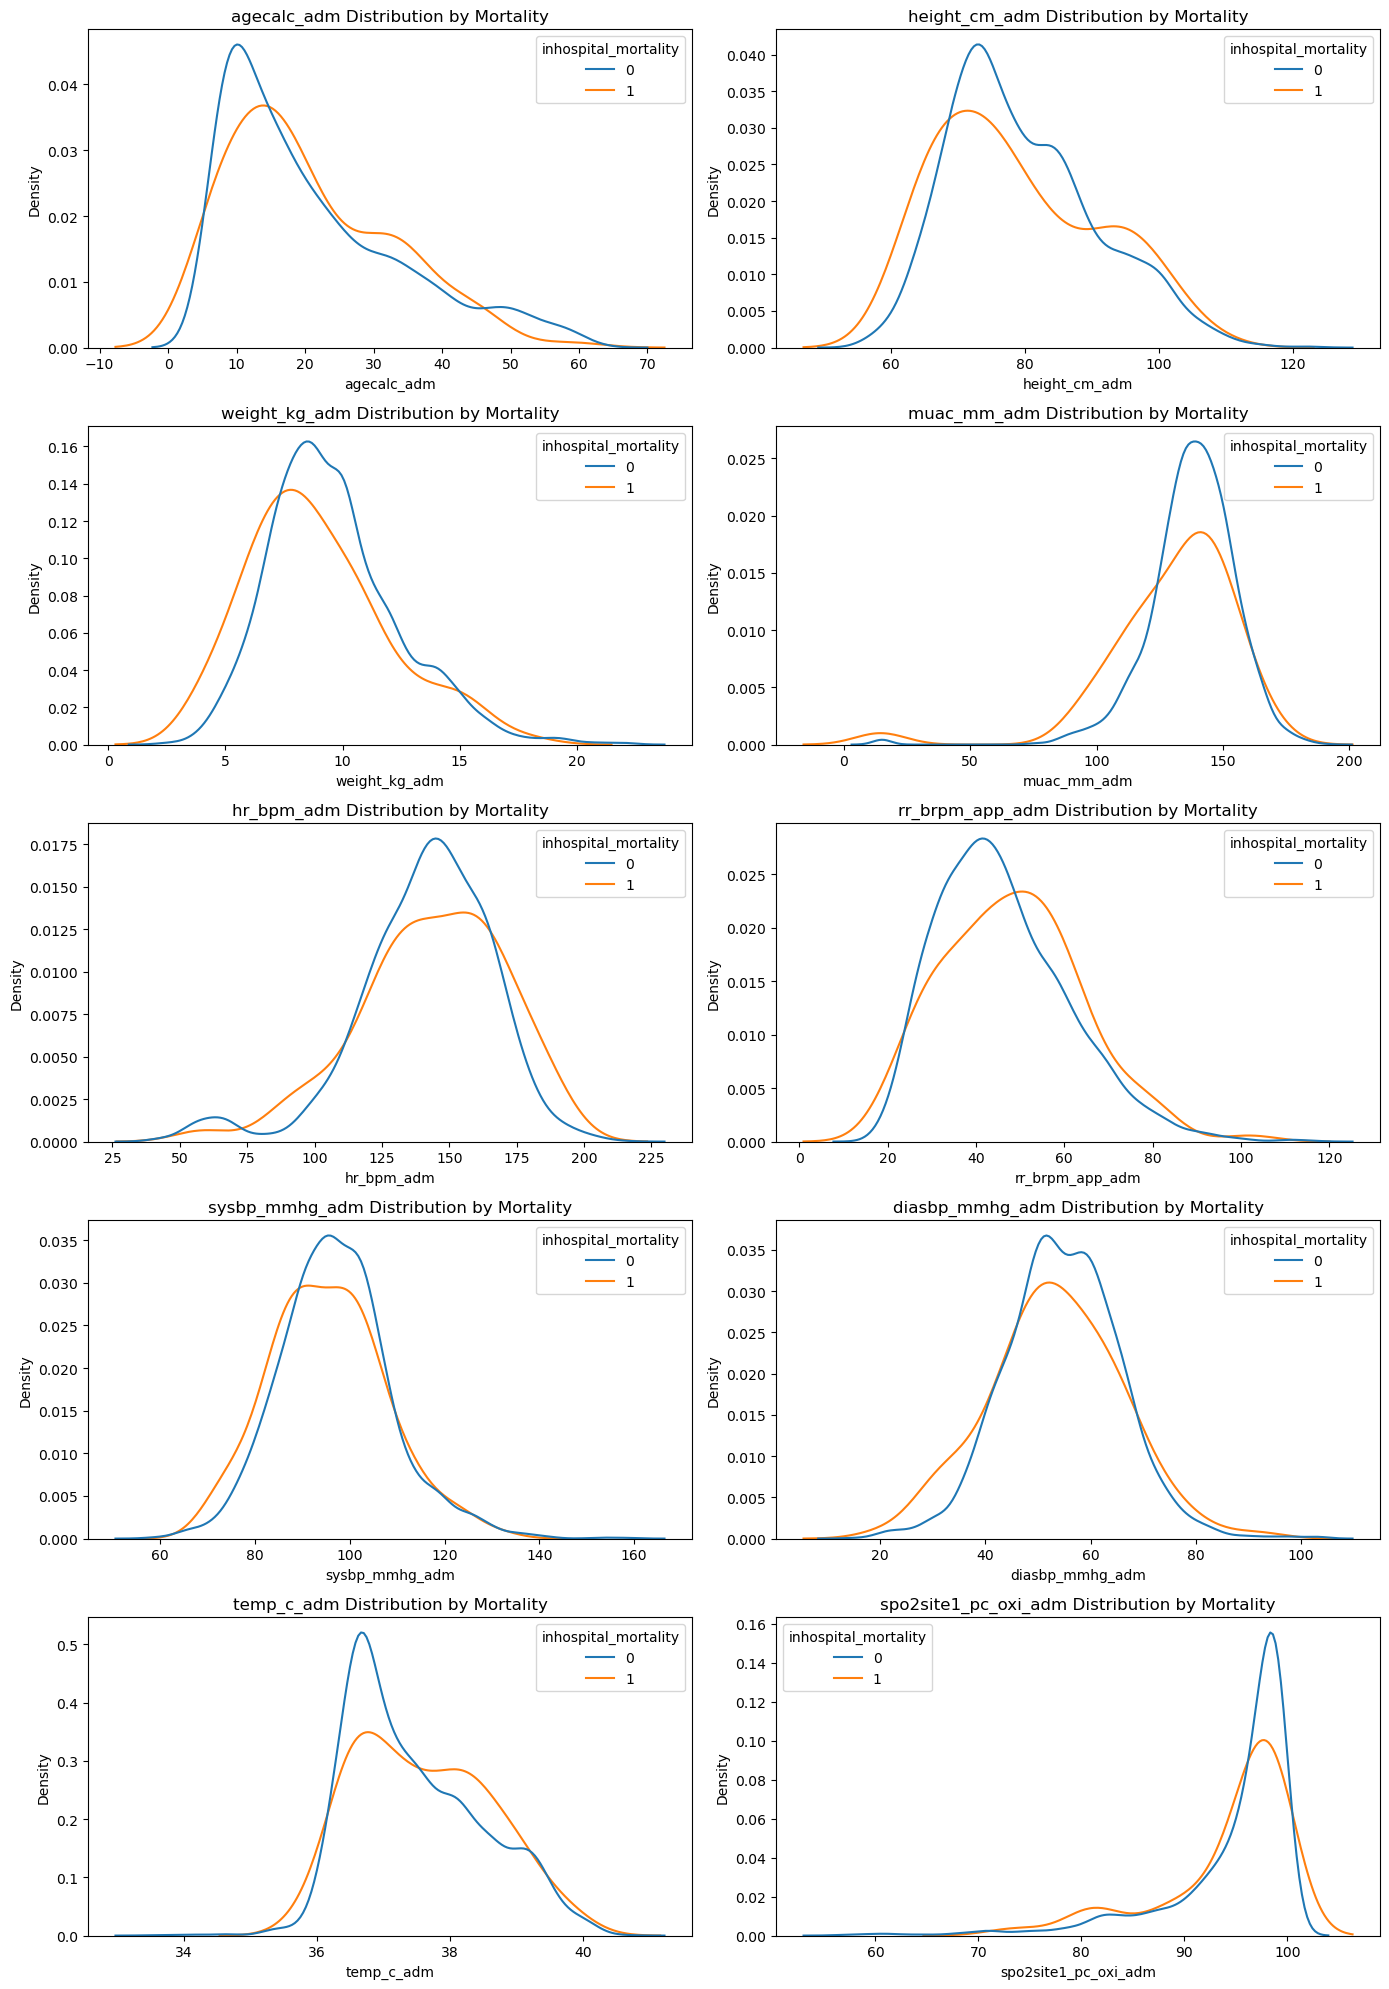

In [331]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of continuous columns
continuous_cols = [
    "agecalc_adm", "height_cm_adm", "weight_kg_adm", "muac_mm_adm", 
    "hr_bpm_adm", "rr_brpm_app_adm", "sysbp_mmhg_adm", "diasbp_mmhg_adm", 
    "temp_c_adm", "spo2site1_pc_oxi_adm"
]

# Set up subplots grid
n_cols = 2
n_rows = (len(continuous_cols) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

# Plot KDEs
for i, col in enumerate(continuous_cols):
    sns.kdeplot(data=sepsis_df, x=col, hue='inhospital_mortality', ax=axes[i], common_norm=False)
    axes[i].set_title(f'{col} Distribution by Mortality')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("kde_distributions_by_mortality.png", dpi=300)  # Save the figure
plt.show()


In [332]:
import plotly.express as px

fig = px.histogram(sepsis_df, x='hivstatus_adm', color='inhospital_mortality', barmode='group',
                   title='Survival Status by HIV Admission Status',
                   labels={'hivstatus_adm': 'HIV Status', 'inhospital_mortality': 'Outcome'})
fig.update_layout(legend_title_text='Patient Status')
fig.show()


In [333]:
print(sepsis_df["hivstatus_adm"].unique())

sepsis_df.columns

['HIV negative' 'HIV positive' 'NotTested']


Index(['studyid_adm', 'agecalc_adm', 'height_cm_adm', 'weight_kg_adm',
       'muac_mm_adm', 'hr_bpm_adm', 'rr_brpm_app_adm', 'sysbp_mmhg_adm',
       'diasbp_mmhg_adm', 'temp_c_adm',
       ...
       'cookloc_adm', 'lightfuel_adm', 'tobacco_adm', 'bednet_adm',
       'hctpretransfusion_adm', 'hivstatus_adm', 'malariastatuspos_adm',
       'lengthadm', 'caregiver_adm_new', 'inhospital_mortality'],
      dtype='object', length=113)

In [334]:
# 1. Distribution of malaria status
fig1 = px.pie(sepsis_df, names='malariastatuspos_adm', title='Malaria Status Distribution')
fig1.show()

# 2. Malaria status vs In-hospital Mortality (Stacked Bar Plot)
fig2 = px.bar(sepsis_df, x='malariastatuspos_adm', color='inhospital_mortality',
              title='Malaria Status vs In-hospital Mortality',
              labels={'malariastatuspos_adm': 'Malaria Status (0: Negative, 1: Positive)',
                      'inhospital_mortality': 'In-hospital Mortality (0: Survived, 1: Died)'},
              color_discrete_map={0: 'green', 1: 'red'}, barmode='stack')
fig2.show()

In [335]:
sepsis_df['malariastatuspos_adm'] = sepsis_df['malariastatuspos_adm'].astype('category')
sepsis_df['inhospital_mortality'] = sepsis_df['inhospital_mortality'].astype('category')


In [336]:
# Check counts for each combination of malaria status and in-hospital mortality
count_data = sepsis_df.groupby(['malariastatuspos_adm', 'inhospital_mortality']).size().reset_index(name='count')
print(count_data)


  malariastatuspos_adm inhospital_mortality  count
0                   No                    0   1761
1                   No                    1     87
2                  Yes                    0    806
3                  Yes                    1     32


In [337]:
import plotly.express as px

# Plot using the grouped data
fig2 = px.bar(count_data, 
              x='malariastatuspos_adm', 
              y='count', 
              color='inhospital_mortality',
              title='Malaria Status vs In-hospital Mortality',
              labels={'malariastatuspos_adm': 'Malaria Status (0: Negative, 1: Positive)',
                      'inhospital_mortality': 'In-hospital Mortality (0: Survived, 1: Died)'},
              color_discrete_map={0: 'green', 1: 'red'},  # Custom color mapping
              barmode='stack')

# Update axis labels to show clearer categories
fig2.update_layout(xaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=['Negative', 'Positive']))

# Show the plot
fig2.show()


#### Malaria Negative (0) Group:
* The majority of patients who are negative for malaria survive (1761).
* A relatively small number of malaria-negative patients die (87).

#### Malaria Positive (1) Group:
* A significant number of malaria-positive patients survive (806), but fewer than those who are malaria-negative.
* The number of malaria-positive patients who die (32) is relatively low compared to the number who survive (806).

### **Encoding Categorical Variables**

#### Understanding the Categorical Columns before Encoding

In [338]:
# Identify categorical columns
categorical_cols = sepsis_df.select_dtypes(include='object').columns

# Count unique values in each categorical column
cat_unique_counts = sepsis_df[categorical_cols].nunique().sort_values()

# Create a summary DataFrame
cat_summary = pd.DataFrame({
    'Categorical Variable': cat_unique_counts.index,
    'Unique Values Count': cat_unique_counts.values
})

# Display all rows
pd.set_option('display.max_rows', None)

# Print the full summary
print(cat_summary)


        Categorical Variable  Unique Values Count
0          symptoms_adm___18                    1
1        comorbidity_adm___4                    1
2        comorbidity_adm___2                    2
3        comorbidity_adm___3                    2
4        comorbidity_adm___5                    2
5        comorbidity_adm___6                    2
6        comorbidity_adm___7                    2
7        comorbidity_adm___8                    2
8        comorbidity_adm___9                    2
9       comorbidity_adm___10                    2
10      comorbidity_adm___12                    2
11          duedateknown_adm                    2
12       birthdetail_adm___1                    2
13       birthdetail_adm___2                    2
14       birthdetail_adm___3                    2
15                   sex_adm                    2
16       birthdetail_adm___5                    2
17       birthdetail_adm___6                    2
18              momalive_adm                    2


In [339]:
# Display a few example values from each categorical column
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(sepsis_df[col].unique()[:10])  # Show up to 5 unique non-null values

print(f"Total number of columns encoded: {len(categorical_cols)}")



Column: sex_adm
['Female' 'Male']

Column: spo2onoxy_adm
['No' 'Yes']

Column: oxygenavail_adm
['Oxygen available and not being used' 'Oxygen available and being used'
 'Oxygen not available' 'Oxygen available but not enough']

Column: respdistress_adm
['No' 'Yes']

Column: caprefill_adm
['No' 'Yes']

Column: bcseye_adm
['Watches or follows' 'Fails to watch or follow']

Column: bcsmotor_adm
['Localizes painful stimulus' 'Withdraws limb from painful stimulus'
 'No response or inappropriate response']

Column: bcsverbal_adm
['Cries appropriately with pain, or, if verbal, speaks'
 'Moan or abnormal cry with pain' 'No vocal response to pain']

Column: bcgscar_adm
['Yes' 'No']

Column: vaccmeasles_adm
['Yes' 'No' 'Unknown']

Column: vaccpneumoc_adm
['3 doses' '2 doses' 'Unknown' '0 doses' '1 dose']

Column: vaccpneumocsource_adm
['Self report' 'Card']

Column: vaccdpt_adm
['3 doses' '2 doses' 'Unknown' '0 doses' '1 dose']

Column: vaccdptsource_adm
['Self report' 'Card']

Column: priorweek

* In this project, we worked with a dataset that contains numerous categorical columns, many of which have binary or ordinal values. To efficiently transform these categorical features into numerical formats usable by machine learning models, we opted for Label Encoding and Ordinal Encoding, instead of One-Hot Encoding, for the following reasons:

     #### ✅ *Reasons for Choosing Label and Ordinal Encoding*
  


**1. High Dimensionality Avoidance:**

* One-hot encoding creates a new column for every category, which significantly increases the number of features when applied to many categorical variables (especially those with many unique values like symptoms, comorbidities, or delivery-related details).
* This can lead to sparse and memory-inefficient datasets, making modeling and interpretation more complex.

**2. Binary and Ordinal Variables:**

* Many features in the dataset (e.g., Yes/No, Checked/Unchecked, or health status levels) are either binary or have a clear ordinal relationship (like symptom severity or education level).
* For such variables, Label Encoding (for binary) and Ordinal Encoding (for ordered categories) are more appropriate and preserve the natural order of the values without unnecessary expansion.

**3. Improved Model Efficiency:**

* Tree-based models (e.g., Random Forests, XGBoost) and many other algorithms can natively handle label-encoded ordinal features well, as they do not assume equal distance between categories (unlike linear models).
* This makes label/ordinal encoding both computationally efficient and compatible with many model types.

**4. Domain Relevance:**

* In healthcare data, some features have clinical meaning in their order (e.g., Feeding well, Feeding poorly, Not feeding at all). Using ordinal encoding respects this inherent structure, which one-hot encoding would ignore.

     *🚫 Why Not One-Hot Encoding*

* Leads to Feature Explosion: Many columns like symptoms, comorbidities, and cooking fuel types are already in multi-column format, and applying one-hot encoding again would duplicate or bloat the feature set unnecessarily.

* Harder to Interpret: The model input becomes less interpretable with many sparse dummy variables.

* Not Efficient for Modeling: Models may become slower and more prone to overfitting due to the large number of features created.



### Encoding Ordinal Variables

___
*Ordinal encoding* was applied to several categorical columns in the Sepsis_df dataset. The encoding approach was based on assigning integer values in an order that reflects progression from the least favorable to the most favorable condition. The *smallest value (0)* was assigned to the *worst or least desirable condition, while the **largest value* was assigned to the *best or most desirable condition*.

This method was chosen to preserve the inherent ordinal nature of certain variables, ensuring that their *relative severity, quality, or desirability* was maintained in numerical form.

*Encoding Principle:*

> Worst condition → 0
> 
> Best condition → Highest number

After each column was encoded, the original (uncoded) column was subsequently removed from the dataset.


> Categories such as *'Don't know', **'N/A (in care)', **'Unknown', and **'Other'* represent uncertain or ambiguous information. To minimize the risk of *introducing noise* and *overvaluing uncertain data, all such categories were consistently assigned the **lowest ordinal value* during encoding.
___



#### *Creating a copy of the original dataset before encoding*

In [340]:
sepsis_df_original=sepsis_df.copy()

##### **Encoding 'watersource_adm'**

In [341]:
# Define the custom order for water sources
watersource_order = [
    'Open source (unprotected, stagnant water, dam)',
    'Slow running water',
    'Fast running water',
    'Protected spring',
    'Bore hole',
    'Municipal water'
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[watersource_order])

# Reshape and encode the column
sepsis_df['watersource_adm_encoded'] = encoder.fit_transform(
    sepsis_df[['watersource_adm']]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["watersource_adm"])
# Optionally view the result
print(sepsis_df['watersource_adm_encoded'].head())

0    5.0
1    3.0
2    4.0
3    5.0
4    5.0
Name: watersource_adm_encoded, dtype: float64


##### **Encoding "vaccpneumoc_adm"**

In [342]:
# Define the custom order for water sources
vaccpneumoc_order = [
    "Unknown",
    '0 doses',
    '1 dose',
    '2 doses',
    '3 doses'    
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[vaccpneumoc_order])

# Reshape and encode the column
sepsis_df['vaccpneumoc_adm_encoded'] = encoder.fit_transform(
    sepsis_df[["vaccpneumoc_adm"]]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["vaccpneumoc_adm"])
# Optionally view the result
print(sepsis_df['vaccpneumoc_adm_encoded'].head())

0    4.0
1    3.0
2    4.0
3    4.0
4    4.0
Name: vaccpneumoc_adm_encoded, dtype: float64


* "Unknown" is assigned the lowest rank in the ordinal encoding because it represents missing or unverified information. By placing it at the bottom, the model is less likely to interpret it as having clinical significance or progression compared to known vaccination levels.

##### **Encoding "vaccdpt_adm"**

In [343]:
# Define the custom order for water sources
vaccdpt_order = [
    "Unknown",
    '0 doses',
    '1 dose',
    '2 doses',
    '3 doses'    
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[vaccdpt_order])

# Reshape and encode the column
sepsis_df['vaccdpt_adm_encoded'] = encoder.fit_transform(
    sepsis_df[["vaccdpt_adm"]]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["vaccdpt_adm"])
# Optionally view the result
print(sepsis_df['vaccdpt_adm_encoded'].head())

0    4.0
1    3.0
2    4.0
3    4.0
4    4.0
Name: vaccdpt_adm_encoded, dtype: float64


* "Unknown" is assigned the lowest rank in the ordinal encoding because it represents missing or unverified information. By placing it at the bottom, the model is less likely to interpret it as having clinical significance or progression compared to known vaccination levels.

##### **Encoding "tobacco_adm"**

In [344]:
# Define the custom order for water sources
tobacco_order = [
    "Never",
    'Daily',
    'Weekly',
    'Less than monthly',
    'Monthly'    
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[tobacco_order])

# Reshape and encode the column
sepsis_df['tobacco_adm_encoded'] = encoder.fit_transform(
    sepsis_df[['tobacco_adm']]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["tobacco_adm"])
# Optionally view the result
print(sepsis_df['tobacco_adm_encoded'].head())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: tobacco_adm_encoded, dtype: float64


##### **Encoding "traveldist_adm"**

In [345]:
# Define the custom order for water sources
traveldist_order = [
    "< 30 minutes",
    '30 minutes - 1 hour',
    '1 - 2 hours',
    '2 - 3 hours',
    '3 - 4 hours',
    "4 - 8 hours",
    "> 8 hours"    
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[traveldist_order])

# Reshape and encode the column
sepsis_df['traveldist_adm_encoded'] = encoder.fit_transform(
    sepsis_df[['traveldist_adm']]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["traveldist_adm"])
# Optionally view the result
print(sepsis_df['traveldist_adm_encoded'].head())

0    1.0
1    1.0
2    5.0
3    1.0
4    1.0
Name: traveldist_adm_encoded, dtype: float64


##### **Encoding "feedingstatus_adm"**

In [346]:
# Define the custom order for water sources
feedingstatus_order = [
    "Not feeding at all",
    'Feeding poorly',
    'Feeding well',
       
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[feedingstatus_order])

# Reshape and encode the column
sepsis_df['feedingstatus_adm_encoded'] = encoder.fit_transform(
    sepsis_df[['feedingstatus_adm']]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["feedingstatus_adm"])
# Optionally view the result
print(sepsis_df['feedingstatus_adm_encoded'].head())

0    1.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: feedingstatus_adm_encoded, dtype: float64


##### **Encoding "deliveryloc_adm"**

In [347]:
# Define the custom order for water sources
deliveryloc_order = [
    "Other",
    'Home',
    'Health centre',
    "Clinic",
    "Hospital"
       
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[deliveryloc_order])

# Reshape and encode the column
sepsis_df['deliveryloc_adm_encoded'] = encoder.fit_transform(
    sepsis_df[['deliveryloc_adm']]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["deliveryloc_adm"])
# Optionally view the result
print(sepsis_df['deliveryloc_adm_encoded'].head())

0    2.0
1    4.0
2    4.0
3    4.0
4    4.0
Name: deliveryloc_adm_encoded, dtype: float64


* In this case, "Other" is placed at the lowest rank in the ordinal encoding because it typically represents delivery locations that fall outside of standard healthcare settings. These locations are generally less equipped or less formal, and assigning them the lowest rank reflects their lower expected quality or formality of care compared to hospitals, clinics, or health centers.

##### **Encoding "birthattend_adm"**

In [348]:
# Define the custom order for water sources
birthattend_order = [
    "Other",
    'Relative',
    'Traditional birth attendant',
    "Nurse / midwife",
    "Doctor / Clinical officer"
       
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[birthattend_order])

# Reshape and encode the column
sepsis_df['birthattend_adm_encoded'] = encoder.fit_transform(
    sepsis_df[['birthattend_adm']]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["birthattend_adm"])
# Optionally view the result
print(sepsis_df['birthattend_adm_encoded'].head())

0    3.0
1    4.0
2    3.0
3    3.0
4    3.0
Name: birthattend_adm_encoded, dtype: float64


* In this encoding, "Other" is assigned the lowest rank because it indicates an undefined or unconventional birth attendant, potentially lacking medical training or standardized care practices. The ranking reflects an ascending order of professional medical expertise and reliability, with "Doctor / Clinical officer" at the top due to their advanced clinical qualifications, which are associated with safer delivery outcomes.

##### **Encoding "bcseye_adm"**

In [349]:
# Define the custom order for water sources
bcseye_order = [    
    'Fails to watch or follow',
    "Watches or follows"      
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[bcseye_order])

# Reshape and encode the column
sepsis_df['bcseye_adm_encoded'] = encoder.fit_transform(
    sepsis_df[['bcseye_adm']]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["bcseye_adm"])
# Optionally view the result
print(sepsis_df['bcseye_adm_encoded'].head())

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: bcseye_adm_encoded, dtype: float64


##### **Encoding "bcsmotor_adm"**

In [350]:
# Define the custom order for water sources
bcsmotor_order = [
        'No response or inappropriate response',
        "Localizes painful stimulus",
        "Withdraws limb from painful stimulus"       
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[bcsmotor_order])

# Reshape and encode the column
sepsis_df['bcsmotor_adm_encoded'] = encoder.fit_transform(
    sepsis_df[['bcsmotor_adm']]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["bcsmotor_adm"])
# Optionally view the result
print(sepsis_df['bcsmotor_adm_encoded'].head())

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: bcsmotor_adm_encoded, dtype: float64


##### **Encoding 'exclbreastfed_adm'**

In [351]:
# Define your order
excl_breastfed_order = [
    'Unknown',
    'never exclusively breastfed',
    '1 month',
    '2 months',
    '3 months',
    '4 months',
    '5 months',
    'Currently exclusively breastfed',
    '6 months',
    'More than 6 months',
]

# Instantiate the encoder with the defined order
encoder = OrdinalEncoder(categories=[excl_breastfed_order])

# Apply encoding
sepsis_df['exclbreastfed_adm_encoded'] = encoder.fit_transform(sepsis_df[['exclbreastfed_adm']])
print(sepsis_df[['exclbreastfed_adm', 'exclbreastfed_adm_encoded']].head())
sepsis_df=sepsis_df.drop(columns=["exclbreastfed_adm"])

  exclbreastfed_adm  exclbreastfed_adm_encoded
0          6 months                        8.0
1          6 months                        8.0
2          6 months                        8.0
3           Unknown                        0.0
4          6 months                        8.0


* > **"Currently exclusively breastfed"** was placed just above **"5 months"** in the ordinal scale because the **youngest child admitted in the dataset was 5 months old**. This implies that the **minimum exclusive breastfeeding duration** for this group is at least 5 months, justifying its position above the 5-month category.

##### **Encoding 'oxygenavail_adm'**

In [352]:
# Define the updated logical order from worst to best for oxygen availability
oxygen_order_updated = [
    'Oxygen not available',
    'Oxygen available but not enough',
    'Oxygen available and being used',
    'Oxygen available and not being used'
]

# Initialize the OrdinalEncoder with the specified category order
encoder = OrdinalEncoder(categories=[oxygen_order_updated])

# Apply the encoder to the 'oxygenavail_adm' column and create a new encoded column
sepsis_df['oxygenavail_adm_encoded'] = encoder.fit_transform(sepsis_df[['oxygenavail_adm']])

# Display the original and encoded columns for verification
print(sepsis_df[['oxygenavail_adm', 'oxygenavail_adm_encoded']].head())

# Drop the original (non-encoded) column to clean up the dataset
sepsis_df = sepsis_df.drop(columns=["oxygenavail_adm"])

                       oxygenavail_adm  oxygenavail_adm_encoded
0  Oxygen available and not being used                      3.0
1  Oxygen available and not being used                      3.0
2  Oxygen available and not being used                      3.0
3  Oxygen available and not being used                      3.0
4  Oxygen available and not being used                      3.0


* > Taking into consideration that oxygen availability is a positive factor, the situation **"Oxygen available and not being used"** was interpreted as more favorable than **"Oxygen available and being used"**. This implies that the child was in better condition and did not require oxygen, despite its availability—indicating a less severe illness.

##### **Encoding 'bcsverbal_adm'**

In [353]:
# Define the logical order (worst → best) for the 'bcsverbal_adm' categories
verbal_order = [
    'No vocal response to pain',
    'Moan or abnormal cry with pain',
    'Cries appropriately with pain, or, if verbal, speaks'
]

encoder = OrdinalEncoder(categories=[verbal_order])

sepsis_df['bcsverbal_adm_encoded'] = encoder.fit_transform(sepsis_df[['bcsverbal_adm']])

# Display the original and encoded columns for verification
print(sepsis_df[['bcsverbal_adm', 'bcsverbal_adm_encoded']].head())

# Drop the original (non-encoded) column to clean up the dataset
sepsis_df = sepsis_df.drop(columns=["bcsverbal_adm"])

                                       bcsverbal_adm  bcsverbal_adm_encoded
0  Cries appropriately with pain, or, if verbal, ...                    2.0
1  Cries appropriately with pain, or, if verbal, ...                    2.0
2  Cries appropriately with pain, or, if verbal, ...                    2.0
3  Cries appropriately with pain, or, if verbal, ...                    2.0
4  Cries appropriately with pain, or, if verbal, ...                    2.0


##### **Encoding 'priorhosp_adm'**

In [354]:
# Define the logical order (worst → best)
priorhosp_order = [
    'Dont know',
    '> 1 year',
    '1 month - 1 year',
    '7 days - 1 month',
    '< 7 days',
    'Never'
]

encoder = OrdinalEncoder(categories=[priorhosp_order])

sepsis_df['priorhosp_adm_encoded'] = encoder.fit_transform(sepsis_df[['priorhosp_adm']])
# Display the original and encoded columns for verification
print(sepsis_df[['priorhosp_adm', 'priorhosp_adm_encoded']].head())

# Drop the original (non-encoded) column to clean up the dataset
sepsis_df = sepsis_df.drop(columns=["priorhosp_adm"])

      priorhosp_adm  priorhosp_adm_encoded
0             Never                    5.0
1             Never                    5.0
2  1 month - 1 year                    2.0
3  7 days - 1 month                    3.0
4  7 days - 1 month                    3.0


##### **Encoding 'totalbreastfed_adm'**

In [355]:
# Define the logical order (worst → best)
breastfeeding_order = ['Unknown', '0-3 months','Still being breastfed', '4-6 months', '7-12 months', '>12 months']

# Initialize the OrdinalEncoder with the specified categories
encoder = OrdinalEncoder(categories=[breastfeeding_order])

# Apply the encoding to the 'totalbreastfed_adm' column
sepsis_df['totalbreastfed_adm_encoded'] = encoder.fit_transform(sepsis_df[['totalbreastfed_adm']])
print(sepsis_df[['totalbreastfed_adm', 'totalbreastfed_adm_encoded']].head())

# Drop the original (non-encoded) column to clean up the dataset
sepsis_df = sepsis_df.drop(columns=["totalbreastfed_adm"])

      totalbreastfed_adm  totalbreastfed_adm_encoded
0             >12 months                         5.0
1  Still being breastfed                         2.0
2  Still being breastfed                         2.0
3             >12 months                         5.0
4  Still being breastfed                         2.0


* > **"Still being breastfed"** was placed just above **'0-3 months'** in the ordinal scale because the **youngest child admitted in the dataset was 5 months old**. While it could be reasonable for this category to fall after **'4-6 months'**, the **uncertainty of the data** regarding the exact breastfeeding duration could introduce noise into the model. As a result, this category was positioned above **'0-3 months'** to avoid overvaluing uncertain data.

##### **Encoding 'bednet_adm'**

In [356]:
# Define the logical order (worst → best)
bednet_order = ['Never', 'Sometimes', 'Always']

# Initialize the OrdinalEncoder with the specified categories
encoder = OrdinalEncoder(categories=[bednet_order])

# Apply the encoding to the 'bednet_adm' column
sepsis_df['bednet_adm_encoded'] = encoder.fit_transform(sepsis_df[['bednet_adm']])
print(sepsis_df[['bednet_adm', 'bednet_adm_encoded']].head())

# Drop the original (non-encoded) column to clean up the dataset
sepsis_df = sepsis_df.drop(columns=["bednet_adm"])

  bednet_adm  bednet_adm_encoded
0     Always                 2.0
1     Always                 2.0
2     Always                 2.0
3     Always                 2.0
4  Sometimes                 1.0


##### **Encoding 'badhealthduration_adm'**

In [357]:
# Define the corrected logical order
badhealth_order = ['Unknown', '> 1 year', '1 month - 1 year', '1 week - 1 month', '< 1 week', 'In good health prior to this illness']

# Initialize the OrdinalEncoder with the specified categories
encoder = OrdinalEncoder(categories=[badhealth_order])

# Apply the encoding to the 'badhealthduration_adm' column
sepsis_df['badhealthduration_adm_encoded'] = encoder.fit_transform(sepsis_df[['badhealthduration_adm']])
print(sepsis_df[['badhealthduration_adm', 'badhealthduration_adm_encoded']].head())

# Drop the original (non-encoded) column to clean up the dataset
sepsis_df = sepsis_df.drop(columns=["badhealthduration_adm"])

                  badhealthduration_adm  badhealthduration_adm_encoded
0  In good health prior to this illness                            5.0
1  In good health prior to this illness                            5.0
2  In good health prior to this illness                            5.0
3  In good health prior to this illness                            5.0
4                              < 1 week                            4.0


##### **Encoding 'caregiverage_adm'**

In [358]:
# Define the logical order for the caregiver age
caregiver_age_order = ['N/A (in care)', '< = 18 years old', '> 18 years old', '> 50 years old']

# Initialize the OrdinalEncoder with the specified categories
encoder = OrdinalEncoder(categories=[caregiver_age_order])

# Apply the encoding to the 'caregiverage_adm' column
sepsis_df['caregiverage_adm_encoded'] = encoder.fit_transform(sepsis_df[['caregiverage_adm']])
print(sepsis_df[['caregiverage_adm', 'caregiverage_adm_encoded']].head())

# Drop the original (non-encoded) column to clean up the dataset
sepsis_df = sepsis_df.drop(columns=["caregiverage_adm"])

  caregiverage_adm  caregiverage_adm_encoded
0   > 18 years old                       2.0
1   > 18 years old                       2.0
2   > 18 years old                       2.0
3   > 18 years old                       2.0
4   > 18 years old                       2.0


##### **Encoding 'momedu_adm'**

In [359]:
# Define the logical order for education level
education_order = ['Dont know','No school',  '< = P3', 'P4-P7', 'S1-S6', 'Post secondary (including post S4 technical school)']

# Initialize the OrdinalEncoder with the specified categories
encoder = OrdinalEncoder(categories=[education_order])

# Apply the encoding to the 'momedu_adm' column
sepsis_df['momedu_adm_encoded'] = encoder.fit_transform(sepsis_df[['momedu_adm']])

print(sepsis_df[['momedu_adm', 'momedu_adm_encoded']].head())

# Drop the original (non-encoded) column to clean up the dataset
sepsis_df = sepsis_df.drop(columns=["momedu_adm"])

                                          momedu_adm  momedu_adm_encoded
0  Post secondary (including post S4 technical sc...                 5.0
1  Post secondary (including post S4 technical sc...                 5.0
2                                              S1-S6                 4.0
3  Post secondary (including post S4 technical sc...                 5.0
4                                              P4-P7                 3.0


In [360]:
# List of already encoded columns
already_encoded = [
    'watersource_adm_encoded','vaccpneumoc_adm_encoded','vaccdpt_adm_encoded', 'tobacco_adm_encoded', 'traveldist_adm_encoded', 'feedingstatus_adm_encoded',
    'deliveryloc_adm_encoded', 'birthattend_adm_encoded', 'bcseye_adm_encoded', 'bcsmotor_adm_encoded',
    'exclbreastfed_adm_encoded', 'oxygenavail_adm_encoded', 'bcsverbal_adm_encoded',
    'priorhosp_adm_encoded', 'totalbreastfed_adm_encoded', 'bednet_adm_encoded',
    'badhealthduration_adm_encoded', 'caregiverage_adm_encoded', 'momedu_adm_encoded'
]

# Display a few example values from each categorical column
for col in already_encoded:
    print(f"\nColumn: {col}")
    print(sepsis_df[col].unique()[:10])  # Show up to 10 unique non-null values

print(f"Total number of columns encoded: {len(already_encoded)}")


Column: watersource_adm_encoded
[5. 3. 4. 0. 2. 1.]

Column: vaccpneumoc_adm_encoded
[4. 3. 0. 1. 2.]

Column: vaccdpt_adm_encoded
[4. 3. 0. 1. 2.]

Column: tobacco_adm_encoded
[0. 1. 2. 3. 4.]

Column: traveldist_adm_encoded
[1. 5. 2. 3. 0. 4. 6.]

Column: feedingstatus_adm_encoded
[1. 0. 2.]

Column: deliveryloc_adm_encoded
[2. 4. 3. 1. 0.]

Column: birthattend_adm_encoded
[3. 4. 2. 1. 0.]

Column: bcseye_adm_encoded
[1. 0.]

Column: bcsmotor_adm_encoded
[1. 2. 0.]

Column: exclbreastfed_adm_encoded
[8. 0. 6. 1. 4. 5. 9. 3. 2. 7.]

Column: oxygenavail_adm_encoded
[3. 2. 0. 1.]

Column: bcsverbal_adm_encoded
[2. 1. 0.]

Column: priorhosp_adm_encoded
[5. 2. 3. 4. 1. 0.]

Column: totalbreastfed_adm_encoded
[5. 2. 4. 1. 3. 0.]

Column: bednet_adm_encoded
[2. 1. 0.]

Column: badhealthduration_adm_encoded
[5. 4. 1. 2. 3. 0.]

Column: caregiverage_adm_encoded
[2. 3. 1. 0.]

Column: momedu_adm_encoded
[5. 4. 3. 2. 1. 0.]
Total number of columns encoded: 19


### Encoding Nominal Variables

In [361]:
# List of already encoded columns
already_encoded = [
    'watersource_adm_encoded','vaccpneumoc_adm_encoded','vaccdpt_adm_encoded', 'tobacco_adm_encoded', 'traveldist_adm_encoded', 'feedingstatus_adm_encoded',
    'deliveryloc_adm_encoded', 'birthattend_adm_encoded', 'bcseye_adm_encoded', 'bcsmotor_adm_encoded',
    'exclbreastfed_adm_encoded', 'oxygenavail_adm_encoded', 'bcsverbal_adm_encoded',
    'priorhosp_adm_encoded', 'totalbreastfed_adm_encoded', 'bednet_adm_encoded',
    'badhealthduration_adm_encoded', 'caregiverage_adm_encoded', 'momedu_adm_encoded'
]

# Get all object or category dtype columns (i.e., categorical)
nominal_cols = sepsis_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Filter to get columns that haven't been encoded yet
to_encode = [col for col in nominal_cols if col not in already_encoded]

# Apply LabelEncoder to each of these remaining columns
le = LabelEncoder()
for col in to_encode:
    sepsis_df[col] = le.fit_transform(sepsis_df[col].astype(str))  # convert to string to handle 'Unknown' etc.

print("Label encoding applied to the following columns:")
print(to_encode)

Label encoding applied to the following columns:
['sex_adm', 'spo2onoxy_adm', 'respdistress_adm', 'caprefill_adm', 'bcgscar_adm', 'vaccmeasles_adm', 'vaccpneumocsource_adm', 'vaccdptsource_adm', 'priorweekabx_adm', 'priorweekantimal_adm', 'symptoms_adm___1', 'symptoms_adm___2', 'symptoms_adm___3', 'symptoms_adm___4', 'symptoms_adm___5', 'symptoms_adm___6', 'symptoms_adm___7', 'symptoms_adm___8', 'symptoms_adm___9', 'symptoms_adm___10', 'symptoms_adm___11', 'symptoms_adm___12', 'symptoms_adm___13', 'symptoms_adm___14', 'symptoms_adm___15', 'symptoms_adm___16', 'symptoms_adm___18', 'comorbidity_adm___1', 'comorbidity_adm___2', 'comorbidity_adm___3', 'comorbidity_adm___4', 'comorbidity_adm___5', 'comorbidity_adm___6', 'comorbidity_adm___7', 'comorbidity_adm___8', 'comorbidity_adm___9', 'comorbidity_adm___10', 'comorbidity_adm___11', 'comorbidity_adm___12', 'prioryearwheeze_adm', 'prioryearcough_adm', 'diarrheaoften_adm', 'tbcontact_adm', 'duedateknown_adm', 'birthdetail_adm___1', 'birthde

In [362]:
print(f"Total number of columns encoded: {len(to_encode)}")

Total number of columns encoded: 71


#### *🧾 Why Label Encoding Was Applied to Remaining Categorical Columns*

* After identifying a list of columns that were already encoded, we detected other categorical columns that still needed transformation. These remaining columns were non-numeric and not yet encoded, so we applied Label Encoding to convert them into numeric values.

*Label Encoding was chosen here because:*

* These columns lack a natural order, making one-hot encoding possible, but we avoided it to prevent dimensionality explosion.

* The dataset already had many features, and label encoding ensures compactness without creating additional columns.

* Most of these features are binary or have a limited number of categories, so label encoding is efficient and appropriate.



In [363]:
for col in nominal_cols[:7]:  # Check first 7 as sample
    print(f"\n{col}:")
    print(sepsis_df[[col]].drop_duplicates().sort_values(col))


sex_adm:
   sex_adm
0        0
2        1

spo2onoxy_adm:
    spo2onoxy_adm
0               0
15              1

respdistress_adm:
    respdistress_adm
0                  0
15                 1

caprefill_adm:
   caprefill_adm
0              0
8              1

bcgscar_adm:
    bcgscar_adm
17            0
0             1

vaccmeasles_adm:
   vaccmeasles_adm
2                0
5                1
0                2

vaccpneumocsource_adm:
    vaccpneumocsource_adm
16                      0
0                       1


In [364]:
#print(f"Total number of total columns: {sepsis_df.columns}")
print(sepsis_df.head(7))

   studyid_adm  agecalc_adm  height_cm_adm  weight_kg_adm  muac_mm_adm  \
0            1         16.8           79.8           11.6        150.0   
1            2         46.1           93.0           13.6        151.0   
2            3          7.9           68.2            8.2        148.0   
3            4         38.2           95.0           12.0        138.0   
4            5         16.1           83.0           12.0        165.0   
5            6         29.6           84.0           10.0        138.0   
6            7         45.1          102.2           11.0        145.0   

   hr_bpm_adm  rr_brpm_app_adm  sysbp_mmhg_adm  diasbp_mmhg_adm  temp_c_adm  \
0       130.0             23.0            92.0             54.0        36.3   
1       115.0             35.0            72.0             42.0        36.8   
2       150.0             56.0            94.0             51.0        37.2   
3       134.0             38.0            94.0             57.0        37.6   
4       163.

___
At this point all the categorical variables have been encoded.
___

### Random Forest Predictive Model

#### Dropping 'studyid_adm' column

In [365]:
sepsis_df.drop('studyid_adm', axis=1, inplace=True)

### Dropping Certain Columns not necessary for the model

In [366]:
# Define the target column (we will exclude it from variance filtering)
#target_col = 'inhospital_mortality'

# Get feature columns only (exclude target)
#feature_cols = [col for col in sepsis_df.columns if col != target_col]

# Set the threshold (e.g., 3% for binary features → 0.0291 variance)
#threshold = 0.03
#var_threshold = threshold * (1 - threshold)

# Apply VarianceThreshold
#selector = VarianceThreshold(threshold=var_threshold)
#selector.fit(sepsis_df[feature_cols])

# Keep only high-variance columns
#selected_cols = sepsis_df[feature_cols].columns[selector.get_support()].tolist()

# Ensure 'symptoms_adm_15' is retained even if it has low variance
#if 'symptoms_adm_15' not in selected_cols and 'symptoms_adm_15' in feature_cols:
 #   selected_cols.append('symptoms_adm_15')

# Columns to drop (excluding 'symptoms_adm_15' explicitly)
#dropped_cols = [col for col in feature_cols if col not in selected_cols and col != 'symptoms_adm_15']

#print("Drop these low-variance columns:")
#print(dropped_cols)

# Update the dataframe, keeping selected features and the target column
#sepsis_df = sepsis_df[selected_cols + [target_col]]


In [377]:
selected_columns = [
    # Demographics & Vitals
    "agecalc_adm", "sex_adm", "height_cm_adm", "weight_kg_adm", "muac_mm_adm",
    "hr_bpm_adm", "rr_brpm_app_adm", "sysbp_mmhg_adm", "diasbp_mmhg_adm",
    "temp_c_adm", "spo2site1_pc_oxi_adm", "spo2onoxy_adm", "oxygenavail_adm_encoded",

    # Clinical Signs & Severity
    "respdistress_adm", "caprefill_adm",
    "bcseye_adm_encoded", "bcsmotor_adm_encoded", "bcsverbal_adm_encoded",

    # Vaccination & Medication History
    "bcgscar_adm", "vaccmeasles_adm", "vaccpneumoc_adm_encoded", "vaccdpt_adm_encoded",
    "priorweekabx_adm", "priorweekantimal_adm",

    # Symptoms
    "symptoms_adm___1", "symptoms_adm___2", "symptoms_adm___3",
    "symptoms_adm___4", "symptoms_adm___6",
    "symptoms_adm___7", "symptoms_adm___8", "symptoms_adm___9",
    "symptoms_adm___10", "symptoms_adm___11", "symptoms_adm___12",
    "symptoms_adm___14", "symptoms_adm___15", "symptoms_adm___18",

    # Comorbidity
    "comorbidity_adm___10",
    "comorbidity_adm___12",  
    "comorbidity_adm___11",

    # Target Variable
    'inhospital_mortality'
]

# Keep only the selected columns
sepsis_df = sepsis_df[selected_columns]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 2. Define features and target
X = sepsis_df.drop(columns=['inhospital_mortality'])
y = sepsis_df['inhospital_mortality']

# 3. Train-test split before applying SMOTE (ensure test set remains unseen)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Apply SMOTE only to the training set
# Use a higher sampling_strategy to further balance the minority class
sm = SMOTE(random_state=42, sampling_strategy=0.7)  # Increased from default 1.0
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# 5. Initial RF to rank features
rf_initial = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced_subsample',  # Changed to balanced_subsample for better handling of imbalance
    random_state=42
)
rf_initial.fit(X_train_resampled, y_train_resampled)

# 6. Top 30 features by importance
#importance_df = pd.DataFrame({
#    'Feature': X.columns,
 #   'Importance': rf_initial.feature_importances_
#}).sort_values('Importance', ascending=False)
#top_30_features = importance_df.head(30)['Feature'].tolist()
#print("Top 30 features by importance:")
#print(top_30_features)
#X_top = X[top_30_features]

# 7. Split data again using only top features to prevent data leakage
X_train_top = X_train
X_test_top = X_test

# Re-apply SMOTE to the training data with top features
X_train_top_resampled, y_train_resampled = sm.fit_resample(X_train_top, y_train)

# 8. Parameter tuning with focus on recall
# Use GridSearchCV with recall as scoring metric
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='recall',  # Focus on recall
    n_jobs=-1
)

grid_search.fit(X_train_top_resampled, y_train_resampled)
best_params = grid_search.best_params_
print(f"\nBest parameters for high recall: {best_params}")

# 9. Train optimized RF using best parameters
rf_final = RandomForestClassifier(
    **best_params,
    random_state=42
)
rf_final.fit(X_train_top_resampled, y_train_resampled)

# 10. Custom threshold tuning for better recall
# First get predictions with probability
y_proba = rf_final.predict_proba(X_test_top)[:, 1]

# Find optimal threshold that maximizes recall while maintaining reasonable precision
thresholds = np.arange(0.1, 0.25, 0.05)  # Lower thresholds favor recall
best_threshold = 0.5
best_f2 = 0  # Using F2 score which weighs recall higher than precision

for threshold in thresholds:
    # Apply threshold
    y_pred_threshold = (y_proba >= threshold).astype(int)
    # Calculate F2 score (weighs recall higher)
    f2 = fbeta_score(y_test, y_pred_threshold, beta=2)
    precision = precision_score(y_test, y_pred_threshold, zero_division=0)
    recall = recall_score(y_test, y_pred_threshold)
    
    print(f"Threshold: {threshold:.2f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F2: {f2:.3f}")
    
    if f2 > best_f2:
        best_f2 = f2
        best_threshold = threshold

print(f"\nBest threshold for high recall: {best_threshold:.2f}")

# Apply the optimal threshold
y_pred_optimal = (y_proba >= best_threshold).astype(int)

# 11. Evaluate with optimal threshold
print("\nFinal Model Performance with Optimal Threshold:")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.3f}")
print(classification_report(y_test, y_pred_optimal))


# 13. Check for overfitting
# Redefine pipeline with SMOTE and RandomForest
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42, sampling_strategy=0.7)),
    ('rf', RandomForestClassifier(**best_params, random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_recall_scores = []
cv_precision_scores = []
cv_f1_scores = []
cv_auc_scores = []

for train_idx, val_idx in cv.split(X_train_top, y_train):
    X_cv_train, X_cv_val = X_train_top.iloc[train_idx], X_train_top.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Fit pipeline (SMOTE will be applied only on training fold)
    pipeline.fit(X_cv_train, y_cv_train)

    # Predict probabilities and apply optimal threshold
    y_cv_proba = pipeline.predict_proba(X_cv_val)[:, 1]
    y_cv_pred = (y_cv_proba >= best_threshold).astype(int)

    # Record metrics
    cv_recall_scores.append(recall_score(y_cv_val, y_cv_pred))
    cv_precision_scores.append(precision_score(y_cv_val, y_cv_pred, zero_division=0))
    cv_f1_scores.append(f1_score(y_cv_val, y_cv_pred))
    cv_auc_scores.append(roc_auc_score(y_cv_val, y_cv_proba))

print("\nCross-Validation Results (SMOTE inside each fold):")
print(f"Mean Recall: {np.mean(cv_recall_scores):.3f} (±{np.std(cv_recall_scores):.3f})")
print(f"Mean Precision: {np.mean(cv_precision_scores):.3f} (±{np.std(cv_precision_scores):.3f})")
print(f"Mean F1: {np.mean(cv_f1_scores):.3f} (±{np.std(cv_f1_scores):.3f})")
print(f"Mean AUC-ROC: {np.mean(cv_auc_scores):.3f} (±{np.std(cv_auc_scores):.3f})")



✅ Top 30 Important Features
- The model identified the most important factors influencing in-hospital mortality. Key features include:
- Consciousness levels (bcsverbal_adm_encoded, bcseye_adm_encoded, bcsmotor_adm_encoded)
- Oxygen availability (oxygenavail_adm_encoded)
- Feeding status and nutritional status (feedingstatus_adm_encoded, muac_mm_adm)
- Travel method, water source, and malaria status
→ These help assess both the clinical and socioeconomic conditions of the patient.

- Handled class imbalance (many more survivors than deaths) using SMOTE, which synthetically adds more samples for the rare “death” cases.
### Model Type:
- I used Random Forest Classifier, which is an ensemble of decision trees.
- It makes predictions by voting across many decision trees to improve accuracy

### Hyperparameter Tuning:

- I adjusted the model to improve its ability to catch actual deaths (high recall).
- Important parameters tuned: number of trees, tree depth, and how the model splits the data.

### Performance Summary:

- Recall: The model correctly identified ~63% of actual deaths.
- Precision: Out of all predicted deaths, only ~11% were true deaths.
- AUC-ROC: 0.75, which means the model is fairly good at distinguishing between survival and death.
- Cross-validation showed consistent performance, especially in recall.